----
## Technical Report Notebook 2
----
### Tweet Text - Natural Language Processing and EDA

This section of the EDA will analysing the tweet **text** for both events: Brisbane/27th Nov 2014 + Sydney/25th April 2015 and continue cleaning the dataset where appropriate.
The EDA will ompare the key words in the twitter text for both events throughout the 24 hour period and nalyse the key words that surround the term "hail".

The notebook will then extend the analysis onto Topic Modelling (using latent Dirichlet allocation) and sentiment analysis.

----

## 2.i. Twitter Text EDA - Data Cleaning

Firstly I will clean and vectorise the full twitter text data prior to analysis...

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

stops = list(stopwords.words("english"))

In [45]:
# Note these terms were added into stopwords list after the topic modelling (later in the report) as they
# were distorting the groupings
stops.append('youtube')
stops.append('video')
stops.append('via')
stops.append('de')
stops.append('done')
stops.append('amp')
stops.append('like')
stops.append('keep')
stops.append('go')
stops.append('gt')

In [46]:
# Use function from capstone part2 to clean twitter data

def clean_tweet(tweet):

    #Remove links from tweet
    link_remove = re.sub(r"http\S+", "", tweet)
    
    #Remove non-letters from tweet    
    letters = re.sub("[^a-zA-Z]", " ", link_remove) 
    
    #Convert to lower case, split into individual words
    words = letters.lower().split()                             
    
    #Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    #Join the words back into one string separated by space and return the result.
    return (" ".join(meaningful_words))

In [47]:
# Reimport the final CSV for use in the Tweet Text Analysis:

hail_data_final = pd.read_csv("./hail_data_final.csv")
hail_data_final.drop('Unnamed: 0',axis=1)
hail_data_final.shape

(145617, 25)

In [48]:
# Initialize an empty list to hold the full parsed twitter dataset

clean_hail_data = []

# Loop over each tweet and append the cleanded tweet:

for tweet in hail_data_final["Text"]:
    clean_hail_data.append(clean_tweet(tweet))
    
print(clean_hail_data[:10])
print(len(clean_hail_data))

hail_data_final['tweet_words'] = clean_hail_data

['take lightning stroketo create ruin quoax', 'meliscward next storm night', 'daddymattyt tired sun raining viciously thunder lightning', 'dteenergy storm tip smoke carbon monoxide detectors level home close sleeping areas', 'wowrt reedtimmertvn happy thanksgiving incredible western ks sunset taken storm chaser dick mcgowan stormpics', 'one kind car excited lightning rod', 'task flood completed iphone iphonegames gameinsight', 'extension area winter storm warning issued november pm est november est nws', 'storm make sure family prepared download ready emergency preparedness app', 'nigeriainfoph nigerians understand level damage spoken word country nigeria never pblems']
145617


In [49]:
# Initialize the CountVectorizer

# In this updated version I also investigated 2 word ngrams to pick up any damage related terms
# such as "golf-ball" and "tennis-ball", however too many of the bigrams were obvious duplicates of the single terms
# so I reverted back to single words only.

print ("Creating words, please wait...\n")

vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,stop_words = 'english',max_features = 1000) 

# fit_transform() does two functions: First, it fits the model

train_data_features = vectorizer.fit_transform(clean_hail_data)

columns = vectorizer.get_feature_names()

Creating words, please wait...



In [50]:
# Fit cvec and converting the result to a DataFrame.

words_df = pd.DataFrame(vectorizer.transform(clean_hail_data).todense(), columns=vectorizer.get_feature_names())

words_df.fillna(0)

print (words_df.shape)

(145617, 1000)


In [51]:
# Create the final hail_tweet_text dataframe

hail_tweet_text = pd.concat([hail_data_final, words_df], axis=1)
hail_tweet_text.shape

(145617, 1026)

In [52]:
# Print top-20 words found in full dataset:

hail_tweet_text.ix[:,26:-1].sum().nlargest(20)

storm         72046
damage        24034
thunder       22375
today         19776
talking       17814
gemini        17629
lightning     16553
flood         10882
nepal          5497
hail           5006
rain           3827
earthquake     3817
brisbane       2928
new            2824
snow           2534
pm             2532
game           2463
news           2437
weather        2420
big            2369
dtype: int64

#### Why is the term "Gemini" so prevalent?
The term gemini is appearing an unusually high number of times...  Why?

In [53]:
# Filter out words relating to 'Gemini'

hail_tweet_text_gemini = hail_tweet_text[hail_tweet_text['gemini']==1]
hail_tweet_text_gemini.ix[:,26:-1].sum().nlargest(20)

gemini       17627
storm        17625
talking      17625
today        17625
listen           2
really           2
think            2
time             2
bolts            1
caused           1
damage           1
day              1
eye              1
forget           1
im               1
lightning        1
stars            1
thinking         1
aap              0
abc              0
dtype: int64

**Conclusion:** After investigation, it appears this term is appearing with 3 key words (storm, talking and today). After investigation it appears it is related to horoscopes although the source is not Twittascope, which was identified in Capstone part-2. This is clearly unreliable data and would distort the use of the word storm in modelling (which could be a critical predictor of hail), so we will remove it.

In [63]:
# Remove all records with the term gemini:

hail_tweet_text = hail_tweet_text[hail_tweet_text['gemini']==0]

KeyError: 'geminieveryone'

### 2.ii. Bag-of-Words Analysis

In [55]:
# Print top-20 word occurrences for full dataset:

hail_tweet_text.ix[:,26:-1].sum().nlargest(20)

storm           54421
damage          24033
thunder         22375
lightning       16551
flood           10882
nepal            5497
hail             5006
rain             3827
earthquake       3817
brisbane         2928
new              2824
snow             2534
pm               2532
game             2463
news             2437
weather          2420
big              2369
power            2336
quake            2329
thanksgiving     2305
dtype: int64

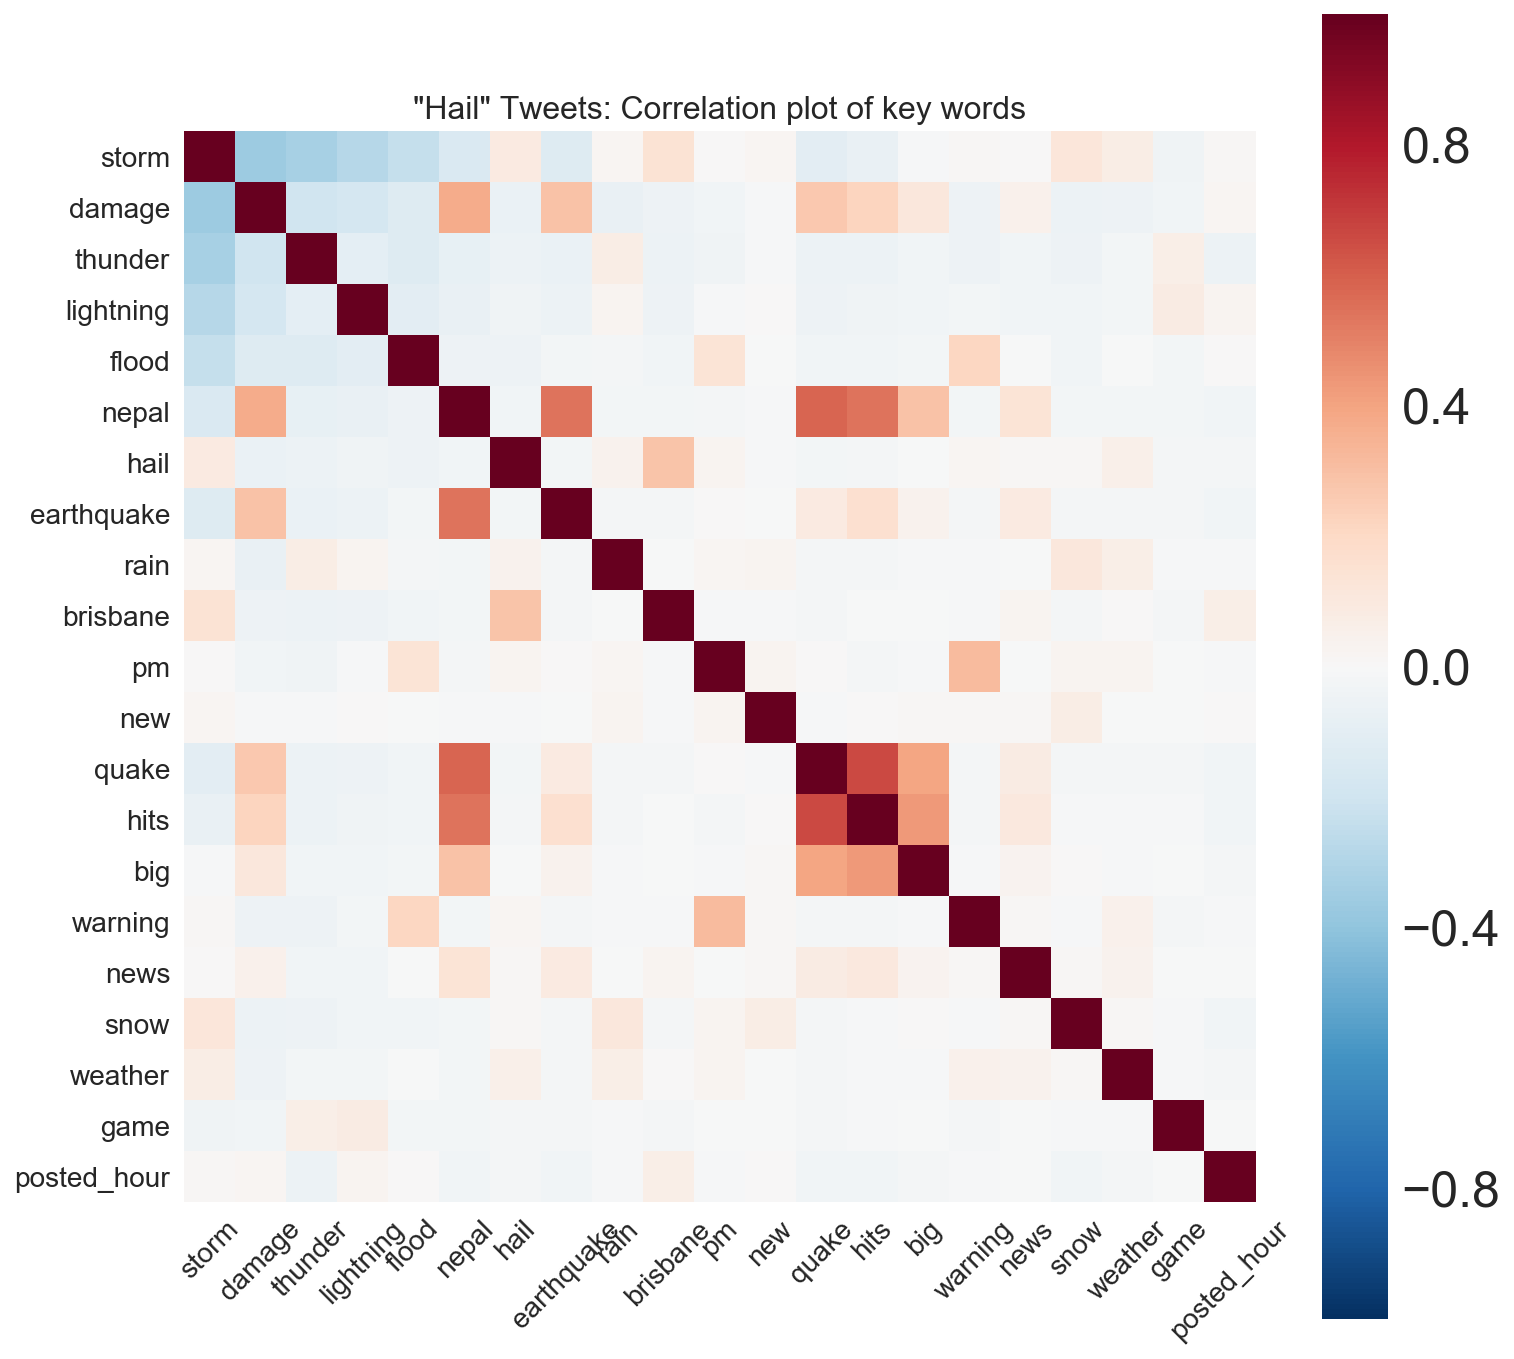

In [56]:
# Correlation plot of top-20 words from full dataset:

hail_tweet_text_top20 = hail_tweet_text[['storm' ,'damage','thunder','lightning','flood','nepal',
                                         'hail','earthquake','rain','brisbane','pm','new','quake','hits',
                                         'big','warning' ,'news','snow','weather','game','posted_hour']]

corr_tt20 = hail_tweet_text_top20.corr()

f, ax = plt.subplots(figsize=(12, 12))

ax = sns.heatmap(data=corr_tt20, square=True, ax=ax)
plt.title('"Hail" Tweets: Correlation plot of key words',size=16)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
plt.show()

#### Word Correlation Discussion: _Earthquake!?_

The most significant correlation found is with an interesting new set of words introducued with the secondary dataset on 25-April-2015...

The highest correlated words are: **quake, hits, big and Nepal...** We can now deduce that the twitter data also picked up another major natural catastrophe on this date: the Nepal Earthquake!

The additional discovery of the earthquake event provides validation of the searching method, showing that this analysis can not only predict hail but also other natural disasters. This increases the scope of the project as well as the potential applications.

_I will now analyse the word counts in greater detail by investigating the distribution of word counts..._

---


#### _Word Count Distributions_

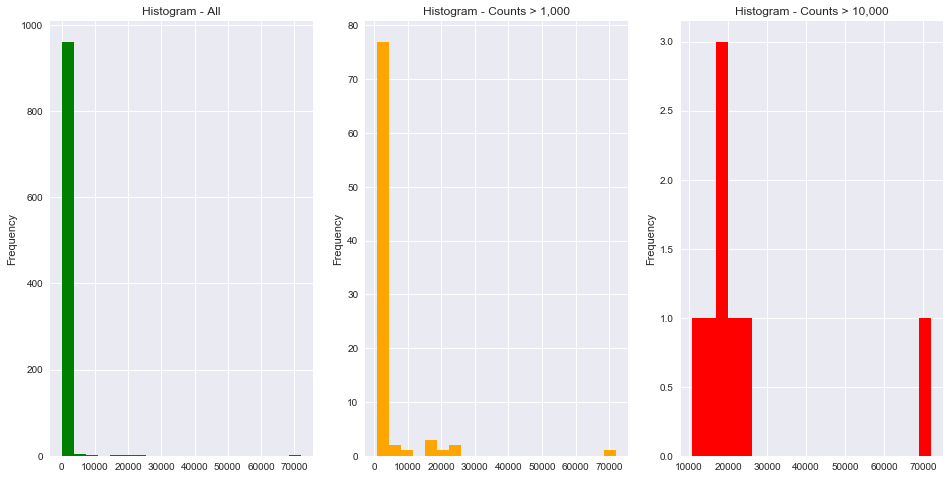

In [16]:
# plotting the count distrubtion of all words in the Twitter data, then filter to greater levels.

hist_counts = pd.Series(words_df.ix[:,26:-1].sum(),index=words_df.columns)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
    
hist_counts.plot(kind="hist", bins=20, ax=axes[0], title="Histogram - All",color='green')
    
# Filtering all words with a count > 1,000
hist_counts[hist_counts > 1000].plot(kind="hist", bins=20, ax=axes[1], title="Histogram - Counts > 1,000",color='orange')
    
# Filtering all words with a count > 10,000
hist_counts[hist_counts > 10000].plot(kind="hist", bins=20, ax=axes[2], title="Histogram - Counts > 10,000",color='red')


These histograms indicate a strong positive skew of word counts, which is expected. When we filter counts above 1,000 and 10,000 we observe groupings in greater detail between 10,000 and 30,000, which implies some words may have been tweeted together often.

Our key investiagtion is into hail, so now I will look specifically at this term and how it differs between datasets...

---

#### Hail Frequency Distribution Over Time

Remember, the two datasets used are from two 24 hour periods where know hail events occurred...

- Cat_ID 144 = Brisbane Hail on 27th Nov 2014
- Cat_ID 154 = Sydney Hail on 25th April 2015

I will now compare the key words in the twitter text for both events through each day's duration. First of all, I will review the key word **'hail'**.

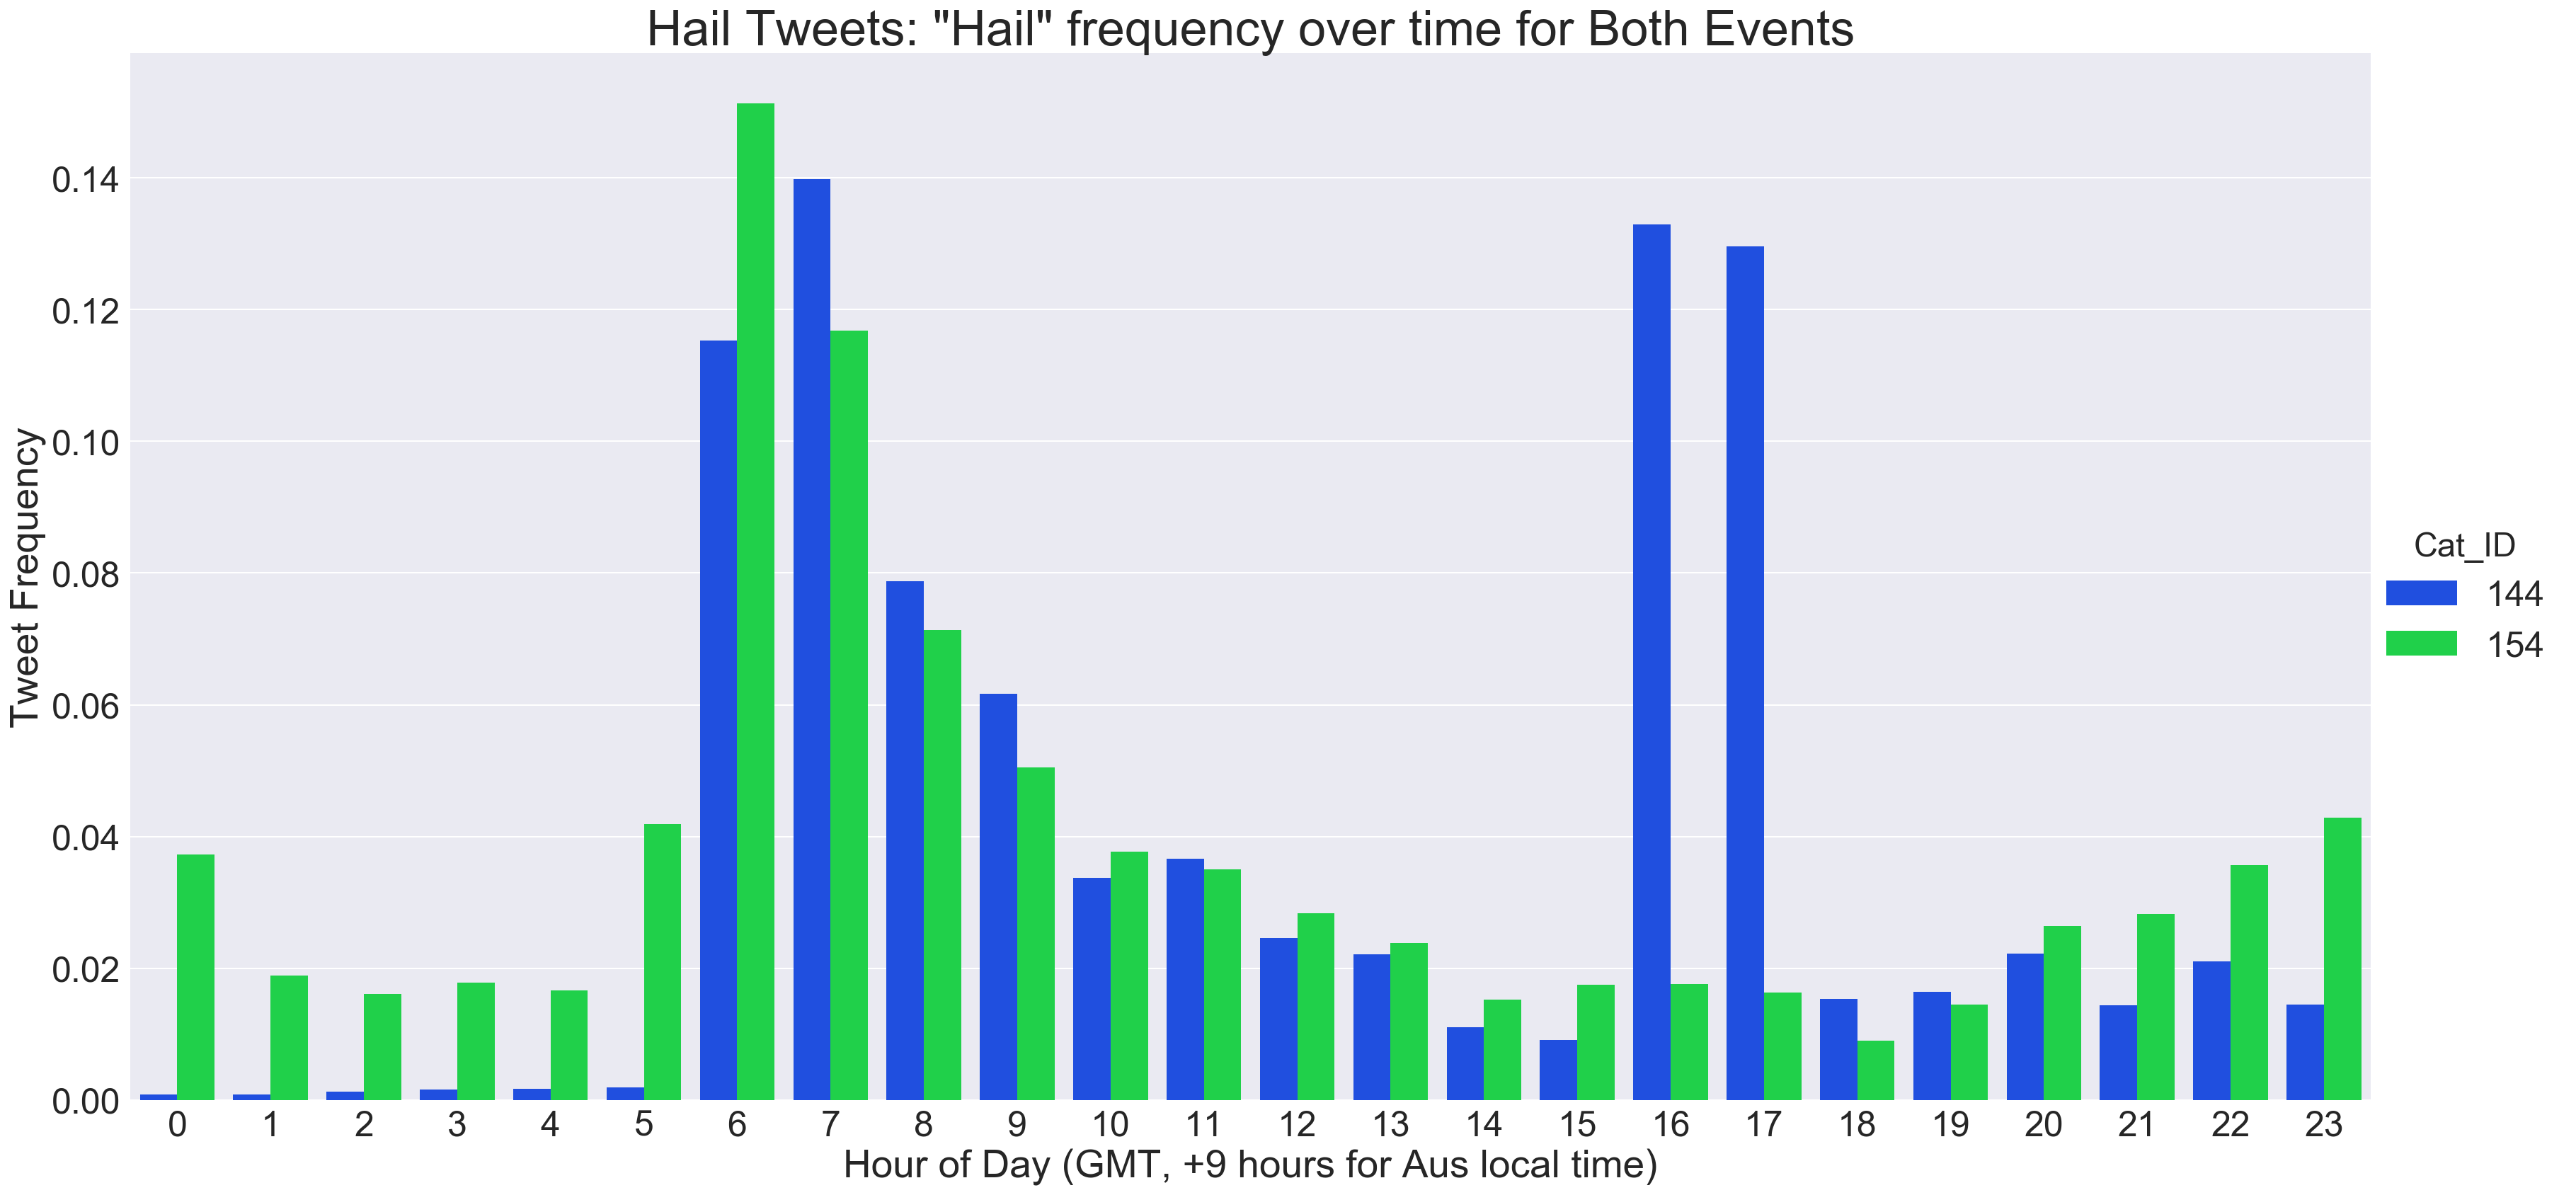

In [64]:
# Frequency plot of the use of the term 'hail' over time:

sns.set(font_scale=2.5)
sns.factorplot(x="posted_hour", y="hail", hue="Cat_ID", data=hail_tweet_text,
                   size=12,aspect=2, kind="bar",palette="bright",ci=None)
plt.title('Hail Tweets: "Hail" frequency over time for Both Events',size=35)
plt.xlabel('Hour of Day (GMT, +9 hours for Aus local time)')
plt.ylabel('Tweet Frequency')
plt.show()

Key insights:
1. Significant peaks at the same same 6-10 hours - this is in line with our known hail event activity on the two days:
  - Brisbane Hail (144) on 27th Nov 14 occurred after 3pm
  - Sydney Hail on 25th April 15 occurred at a similar time. _Hail events are known to impact the East Coast of Australia later in the day in the summer months_
- Brisbane event: what occurring at 16/17 hours? First I will check another key term...

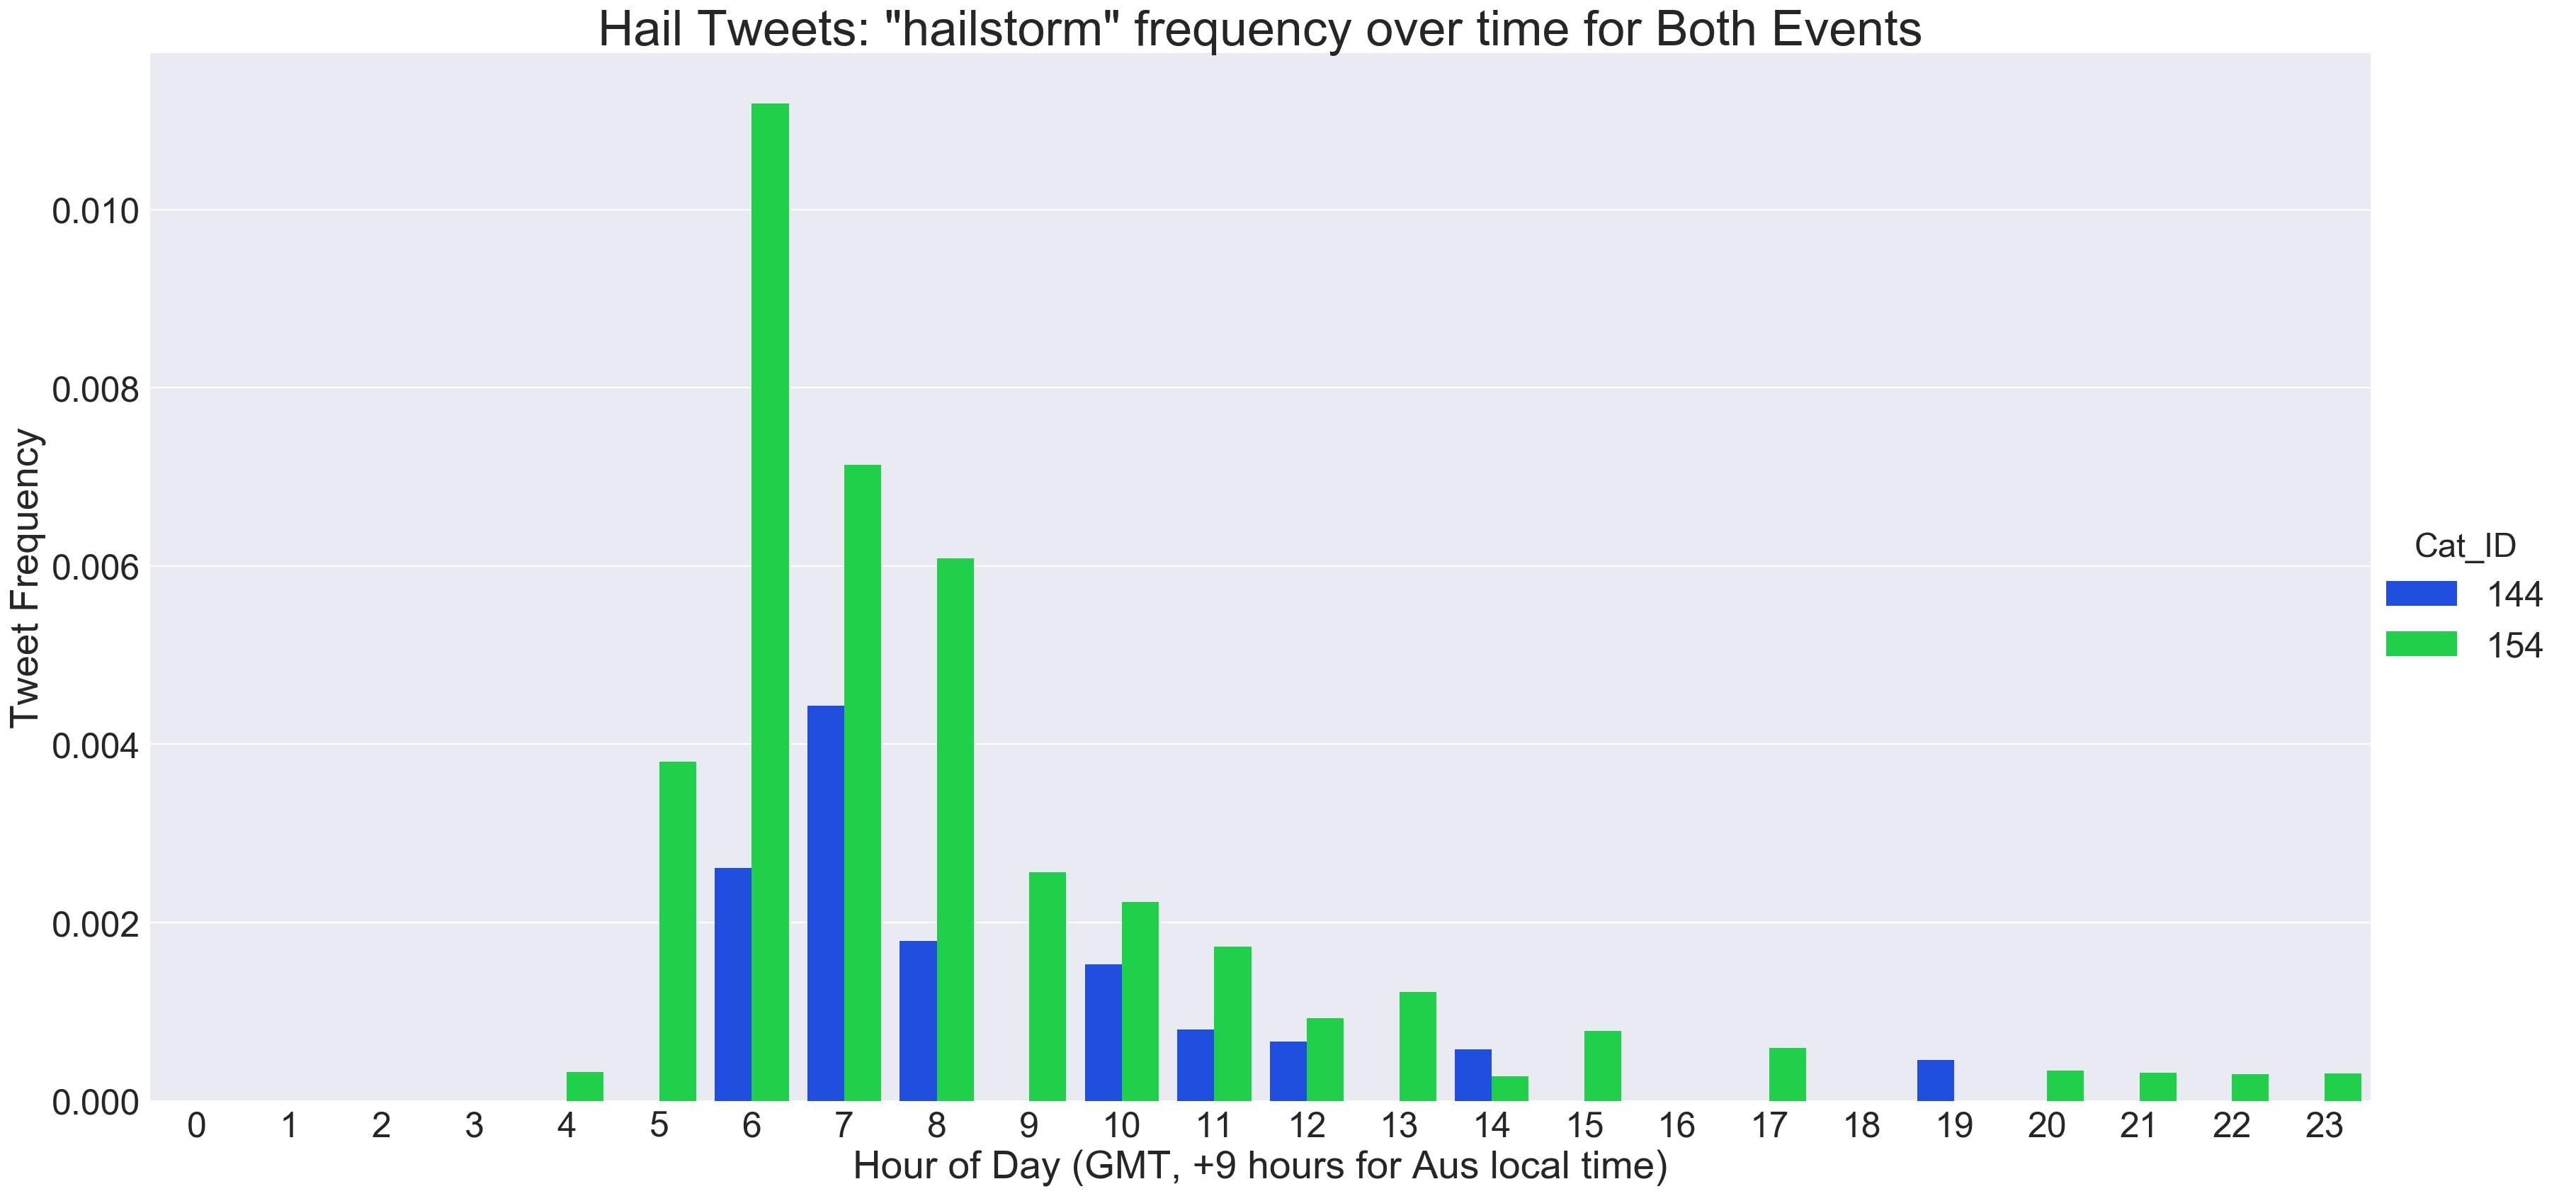

In [66]:
# Plot to check the occurrence of 'hailstorm' for the two events:

plt.figure(figsize=(12,8))
sns.factorplot(x="posted_hour", y="hailstorm", hue="Cat_ID", data=hail_tweet_text,
                   size=12,aspect=2, kind="bar",palette="bright",ci=None)
plt.title('Hail Tweets: "hailstorm" frequency over time for Both Events',size=35)
plt.xlabel('Hour of Day (GMT, +9 hours for Aus local time)')
plt.ylabel('Tweet Frequency')

**Comment:** The 'hailstorm' frequency does not provide any further explanation... What about other words used at this hour?

In [67]:
# Investigation for top 20 words used at hour 17 within the Brisbane/Nov 2014 hail data:

hail_tweet_text_bris = hail_tweet_text[hail_tweet_text['Cat_ID']==144]

hail_tweet_text_bris17 = hail_tweet_text[hail_tweet_text['posted_hour']==17]
print (hail_tweet_text_bris17.ix[:,26:-1].sum().nlargest(20))

storm        2547
damage       1030
thunder       791
lightning     724
flood         582
hail          341
brisbane      298
causes        265
chaos         252
power         195
today         156
pm            152
town          152
new           146
powerful      133
cut           132
thousands     132
rain          126
borno         125
marte         125
dtype: int64


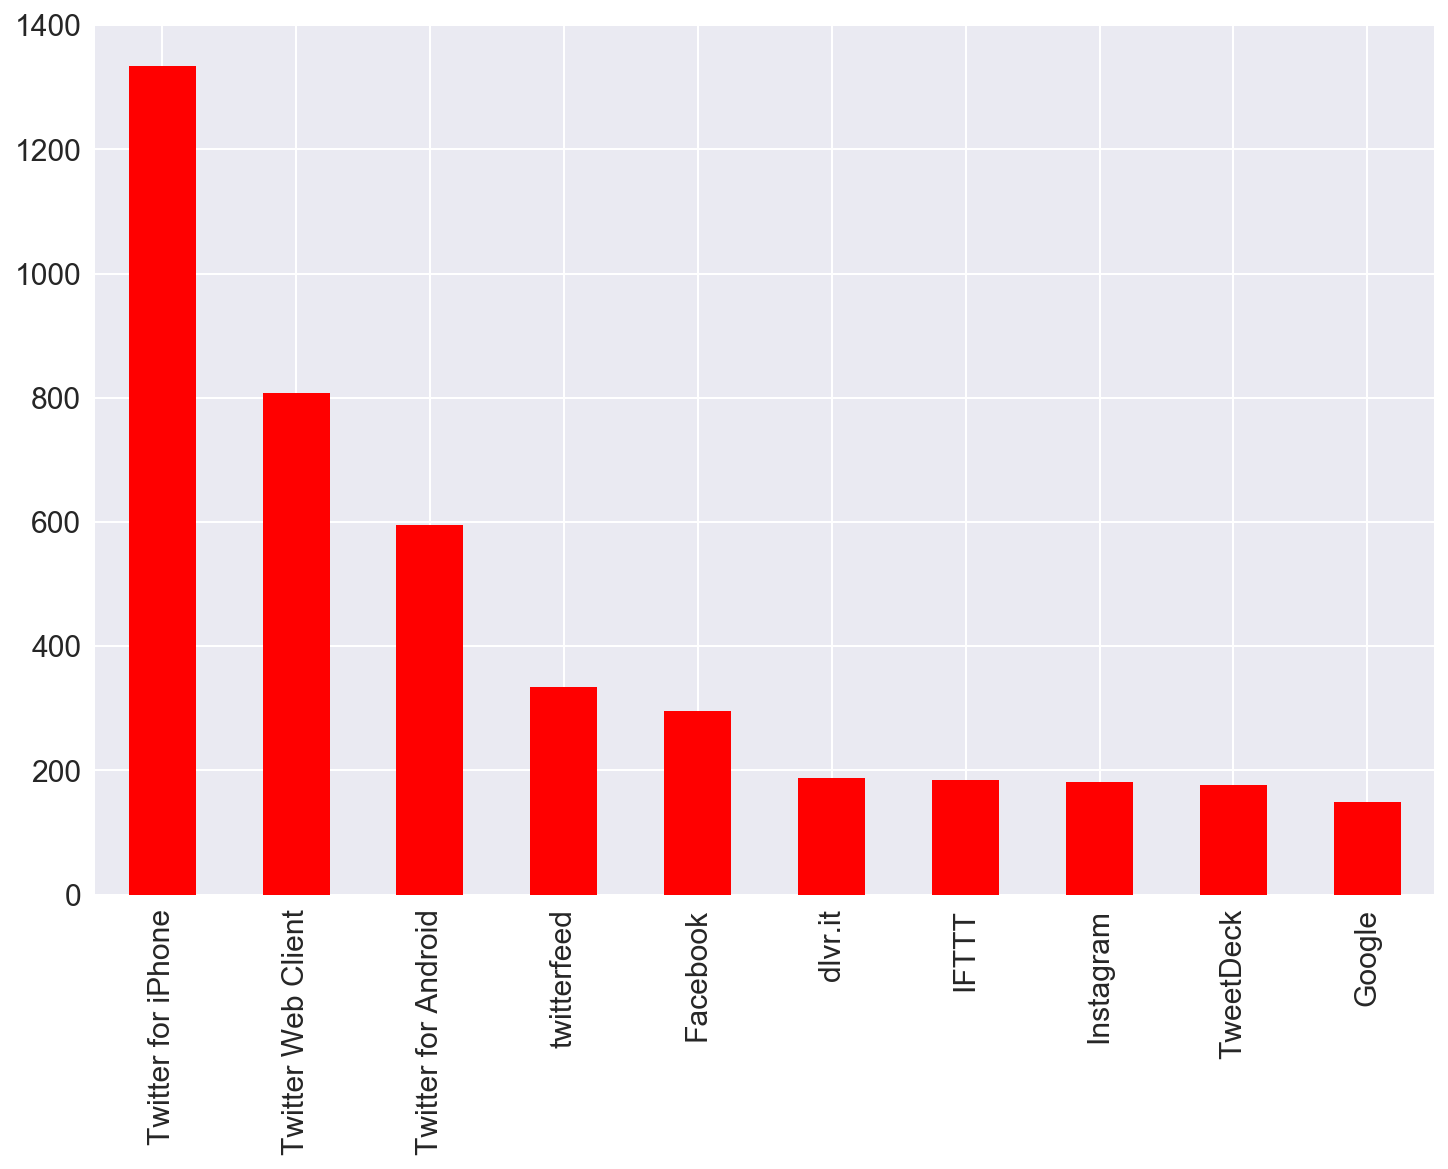

In [68]:
# Plot of source type at hour 17 within the Brisbane/Nov 2014 hail data:

fig = plt.figure(figsize=(12,8))
hail_tweet_text_bris17.source.value_counts().nlargest(10).plot(kind='bar',color='red')
plt.tick_params(labelsize=15)

 #### Brisbane Hail - Hour 17 Discussion?

Inconclusive results:
- Nothing conclusive to indicate the additional signature at hour 17 - nothing is observed from other words and source information...
- It is unclear from this analysis why there is an additional signature later in the day. Possibly international recognition of the event was causing the term to be tweeted?

### "Damage" frequency plot for Both Events:

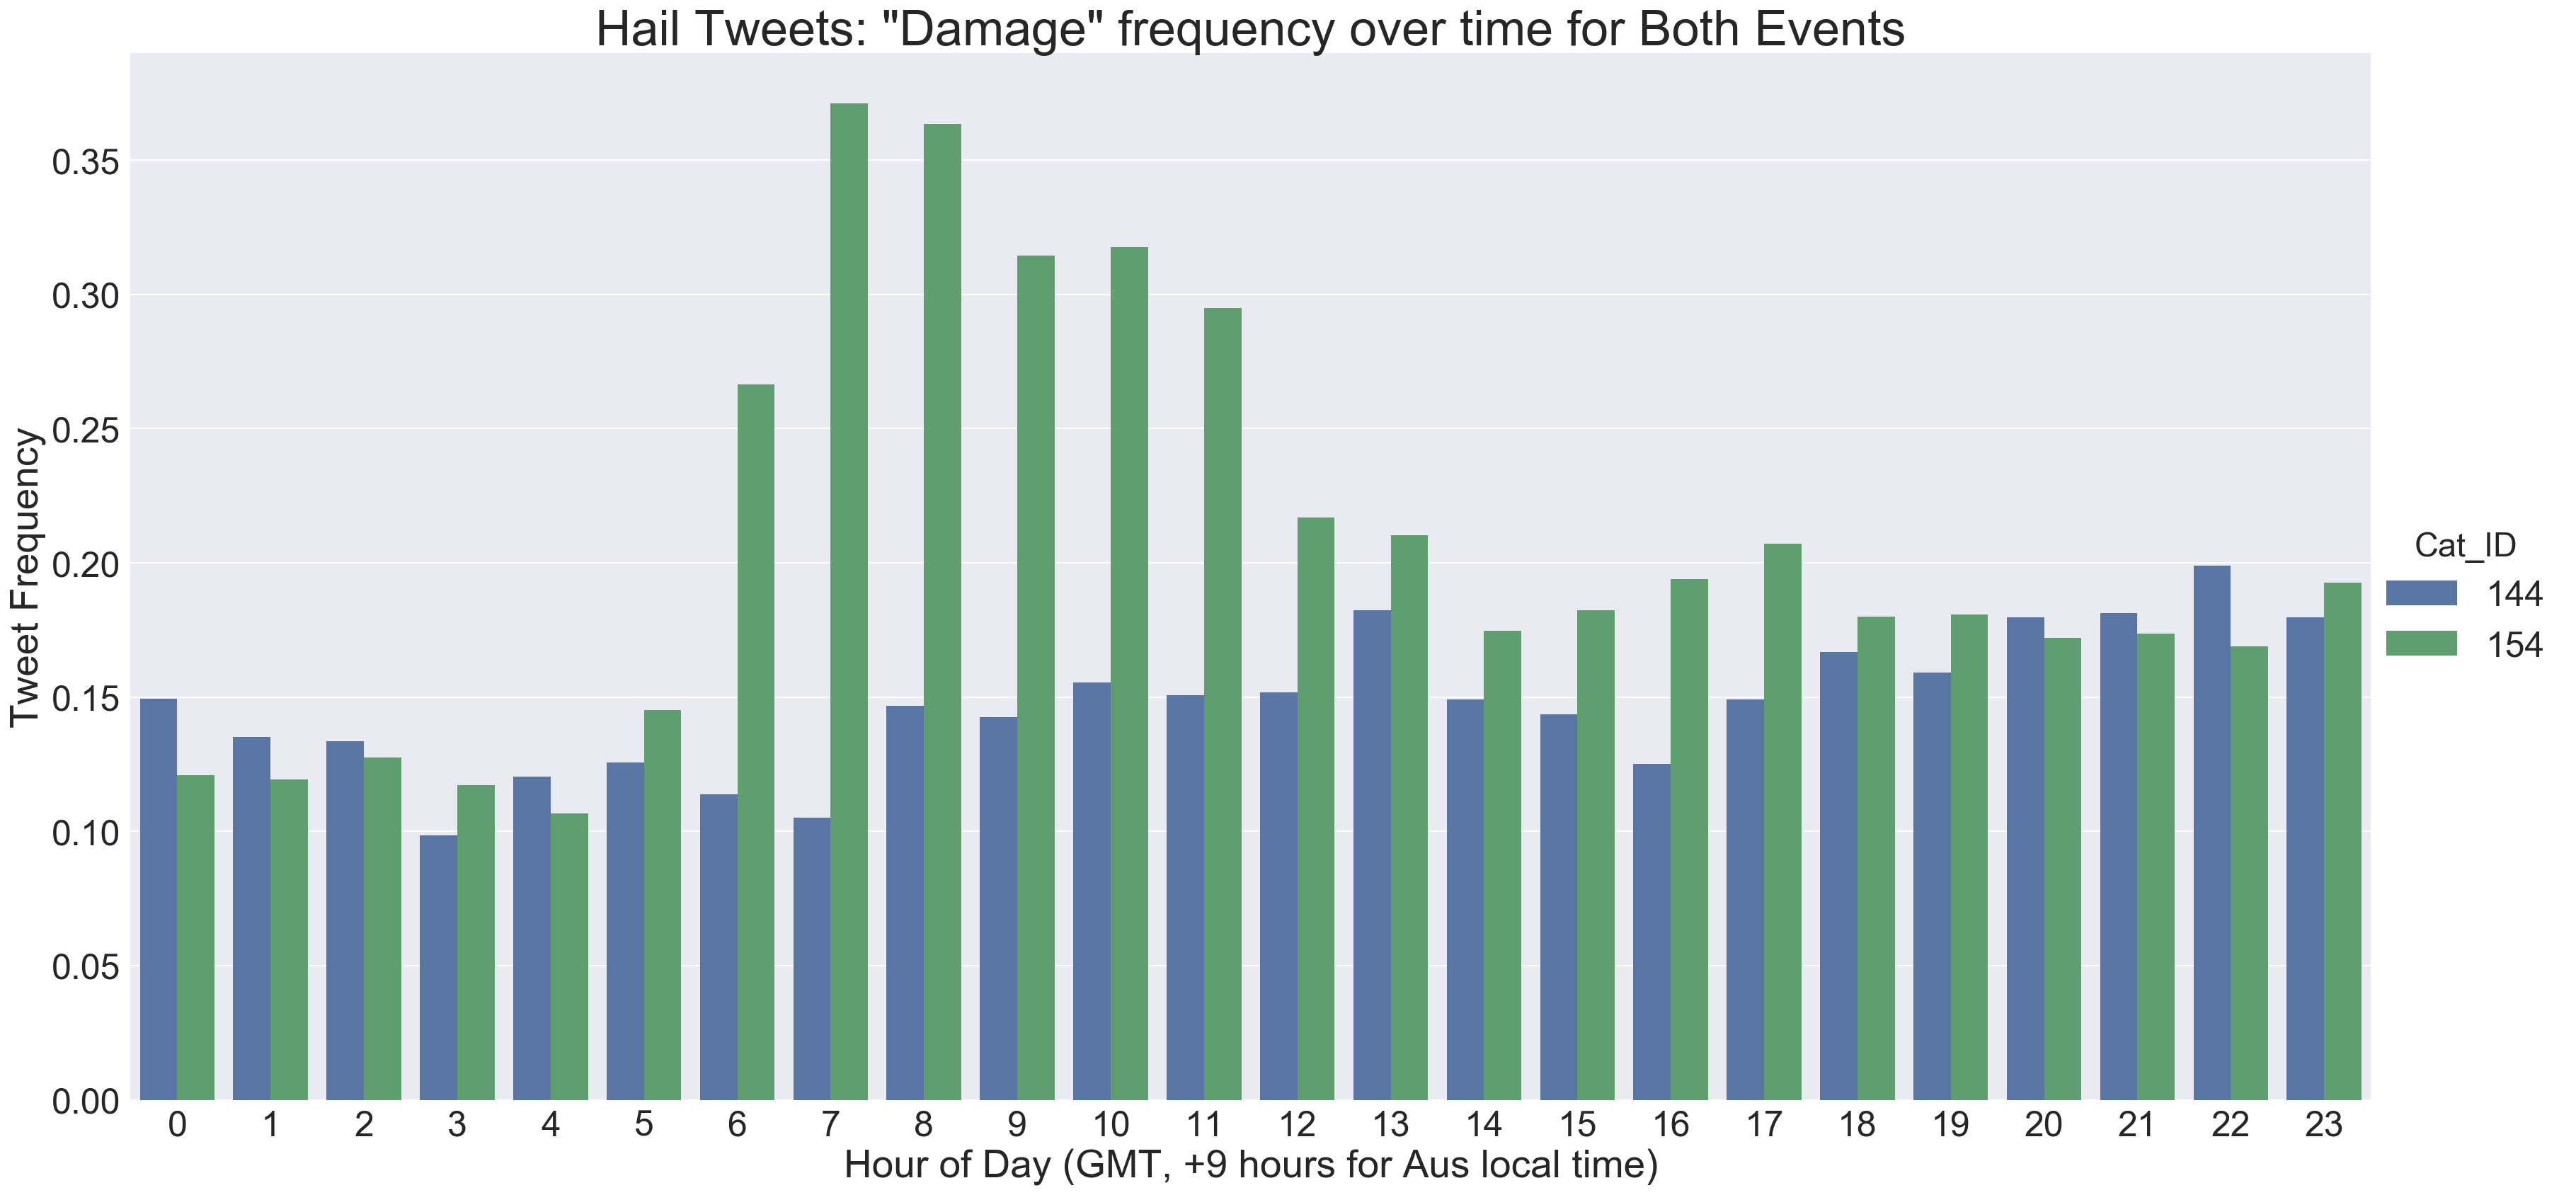

In [69]:
# Damage frequency plot (count vs time) for both events

sns.factorplot(x="posted_hour", y="damage", hue="Cat_ID", data=hail_tweet_text,
                   size=12,aspect=2, kind="bar",ci=None)
plt.title('Hail Tweets: "Damage" frequency over time for Both Events',size=35)
plt.xlabel('Hour of Day (GMT, +9 hours for Aus local time)')
plt.ylabel('Tweet Frequency')

---
#### Key Words - Event Comparison

Analysing the key words that surround the term "hail" for both of the events.

In this analysis I will only look at the twitter data that was posted during the actual hours of the hail storm, from Hour-6 through to Hour-10 (this is a conservative range).

In [70]:
# Filter data into actual storm hours

hail_tt_storm_hours = hail_tweet_text[(hail_tweet_text['posted_hour'] >=6) &\
                                        (hail_tweet_text['posted_hour'] <=10) &\
                                        (hail_tweet_text['hail'] > 0)]

print ("Storm hours data shape:",hail_tt_storm_hours.shape)

print (hail_tt_storm_hours.ix[:,26:-1].sum().nlargest(21))

# Create data of top 20 terms (exlcluding hail)

df = hail_tt_storm_hours.groupby(['Cat_ID'])[['storm','rain','weather'
                                        ,'hit','severe','golf','ball','lightning','thunder','damage','storms'
                                        ,'crazy','snow','australia','sized','news']].sum()
df = df.transpose()
df.columns

Storm hours data shape: (2453, 1026)
hail           2586
storm          1277
sydney          836
brisbane        460
sydneystorm     394
rain            202
weather         184
hit             147
ball            137
golf            132
lightning       129
severe          123
thunder         121
storms          104
crazy           103
damage          102
snow            100
bnestorm         93
australia        91
sized            90
heavy            81
dtype: int64


Int64Index([144, 154], dtype='int64', name='Cat_ID')

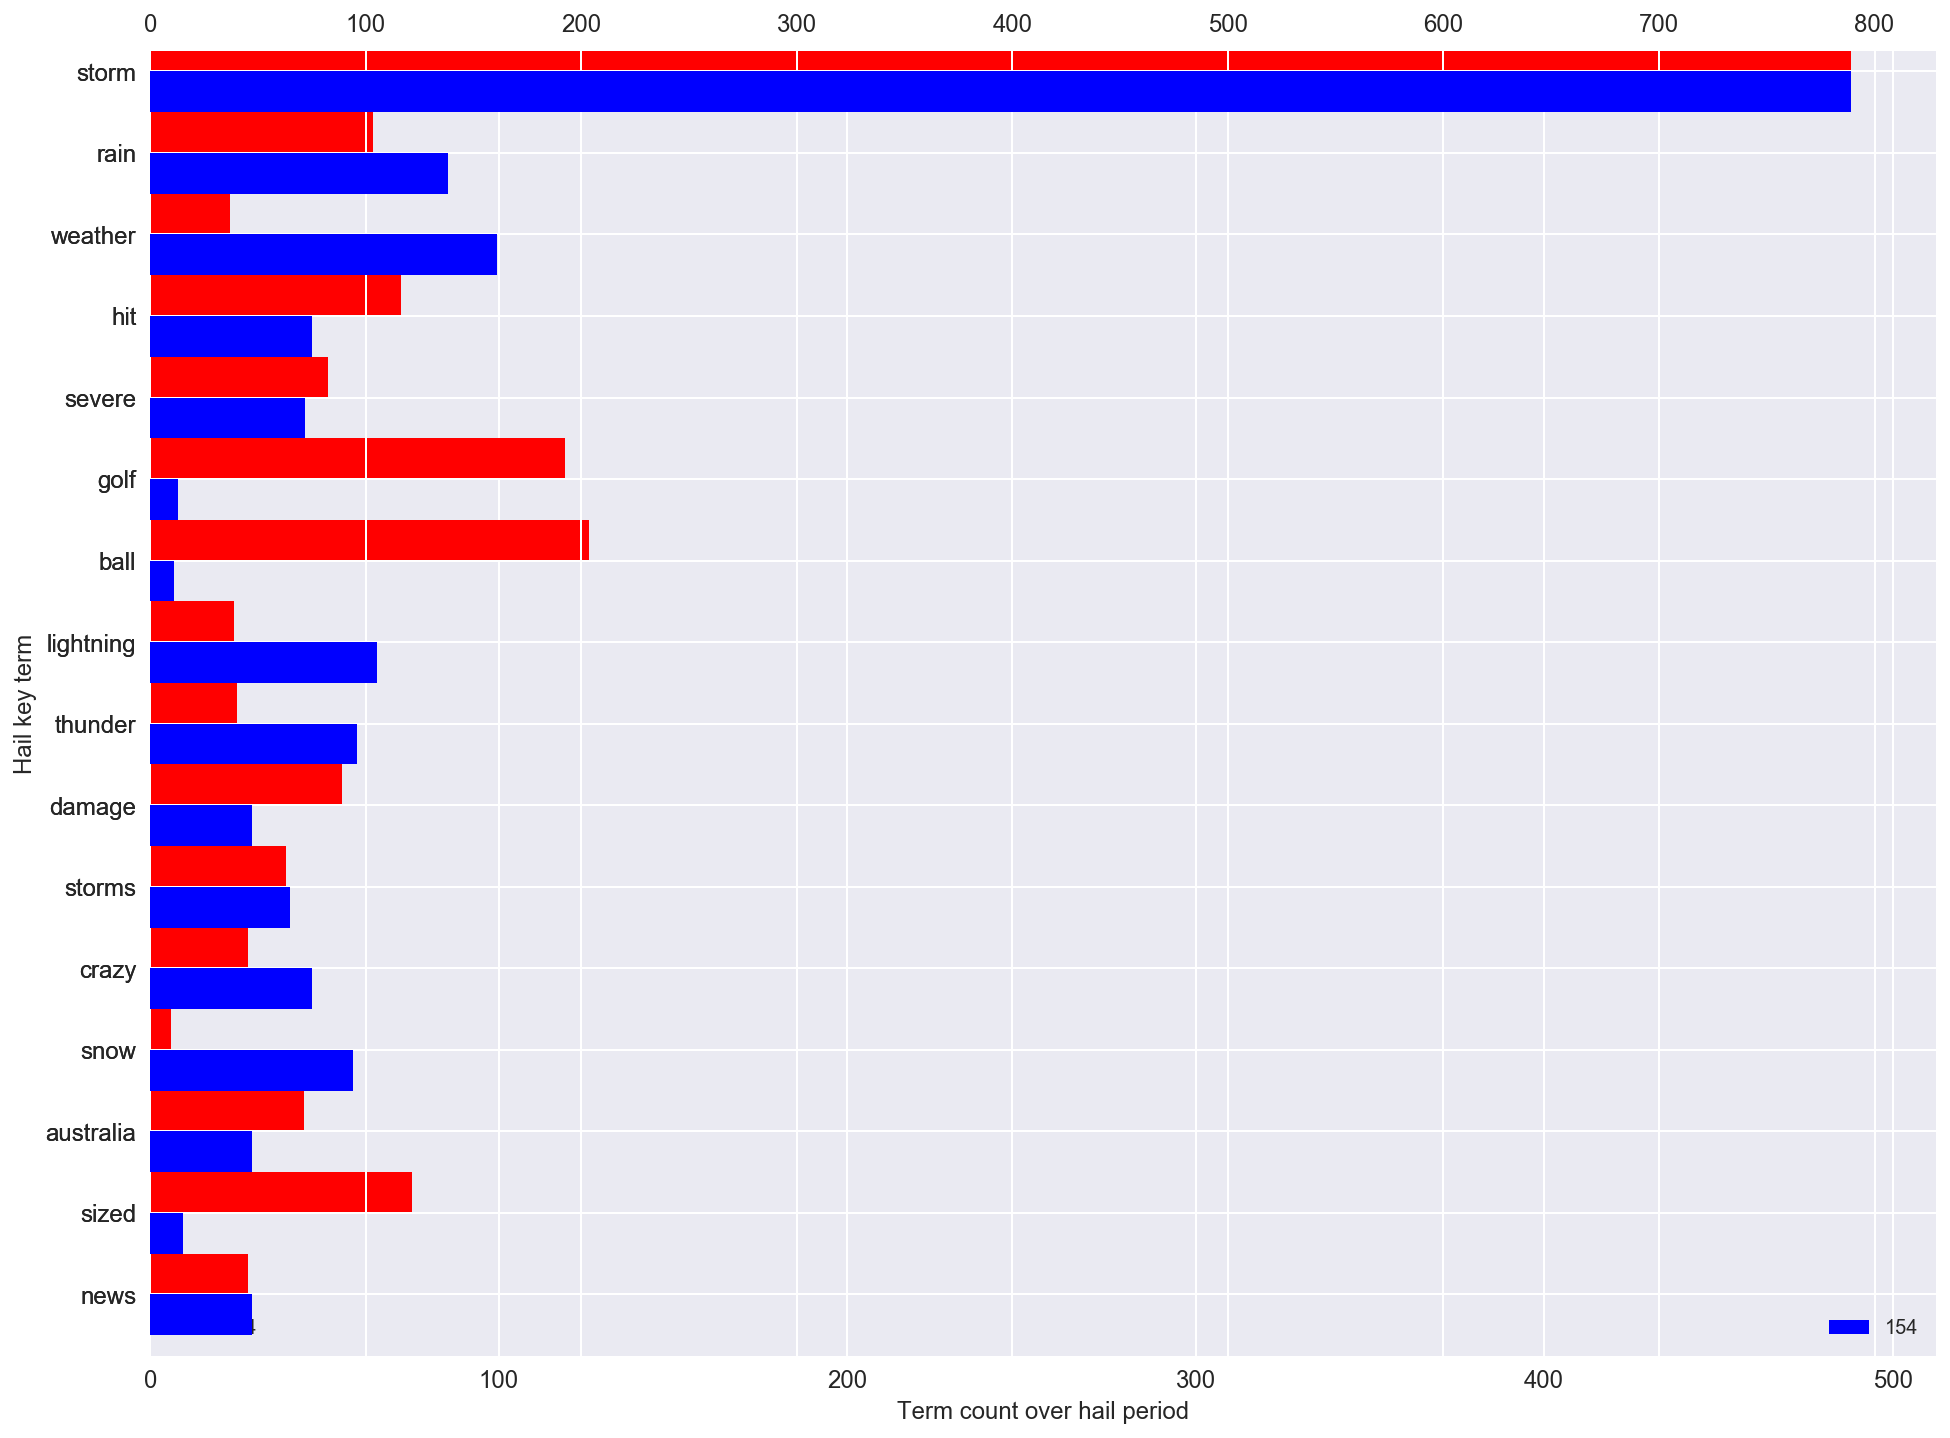

In [73]:
# Plot a comparison chart for the key words used in conjuction with the word 'hail' during of the hailstorm hours:

fig = plt.figure(figsize=(16,12)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twiny() # Create another axes that shares the same x-axis as ax.


df[144].plot(kind='barh', color='red', ax=ax, fontsize=12,legend=True, position=1)
df[154].plot(kind='barh', color='blue', ax=ax2, fontsize=12, legend=True,position=0)

sns.set(font_scale=1)
ax.set_ylabel('Hail key term',size=12)
ax.set_xlabel('Term count over hail period',size=12)
plt.gca().invert_yaxis()
plt.show()

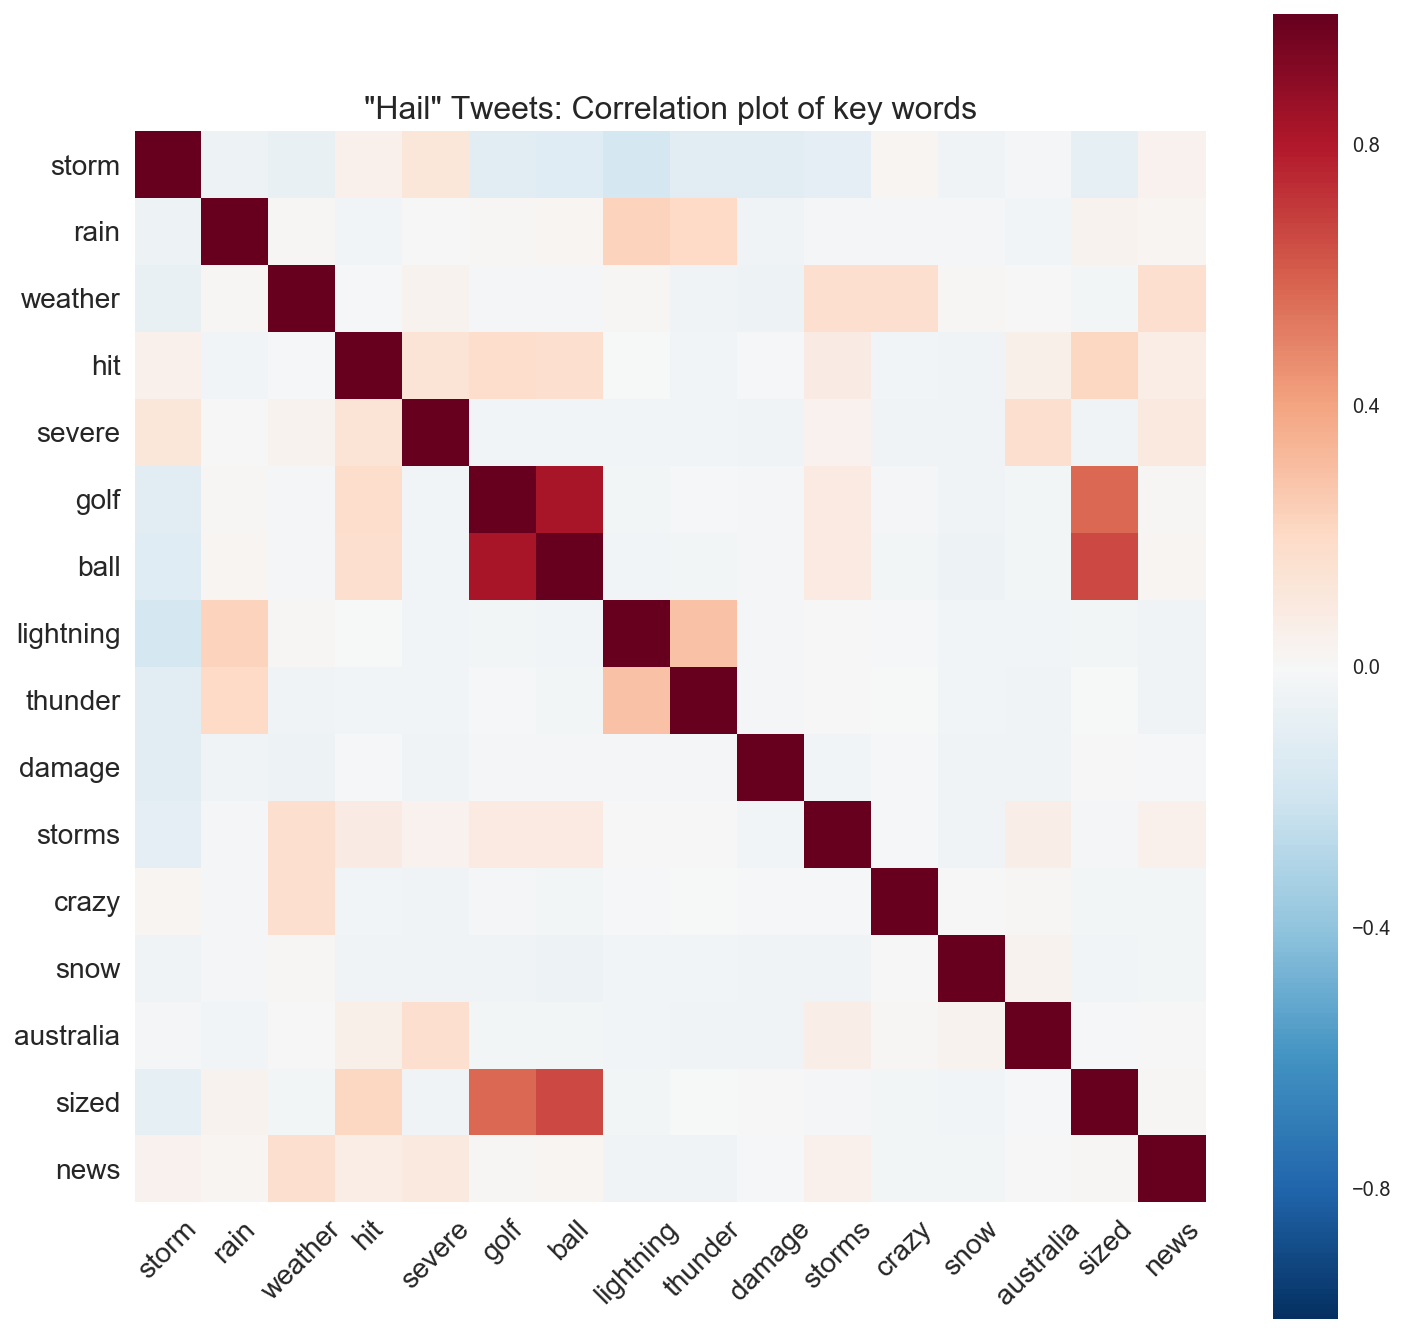

In [74]:
# Correlation plot of key words used with hail

hail_tt_storm_hours_terms = hail_tt_storm_hours[['storm','rain','weather','hit','severe','golf','ball','lightning','thunder','damage','storms','crazy','snow','australia','sized','news']]

hail_tt_storm_hours_corr = hail_tt_storm_hours_terms.corr()

f, ax = plt.subplots(figsize=(12, 12))

ax = sns.heatmap(data=hail_tt_storm_hours_corr, square=True, ax=ax)
plt.title('"Hail" Tweets: Correlation plot of key words',size=16)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
plt.show()

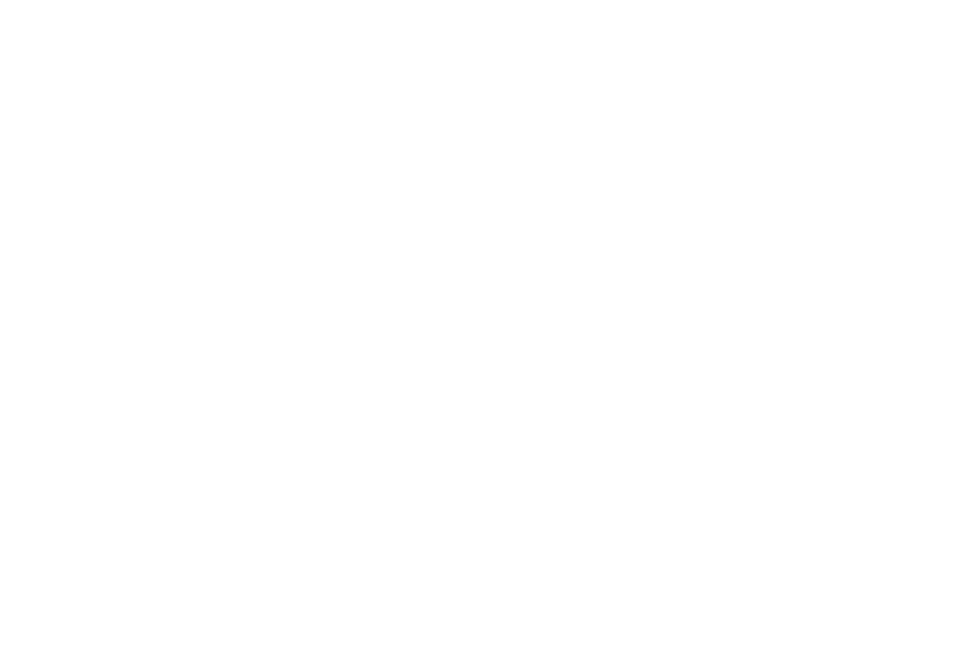

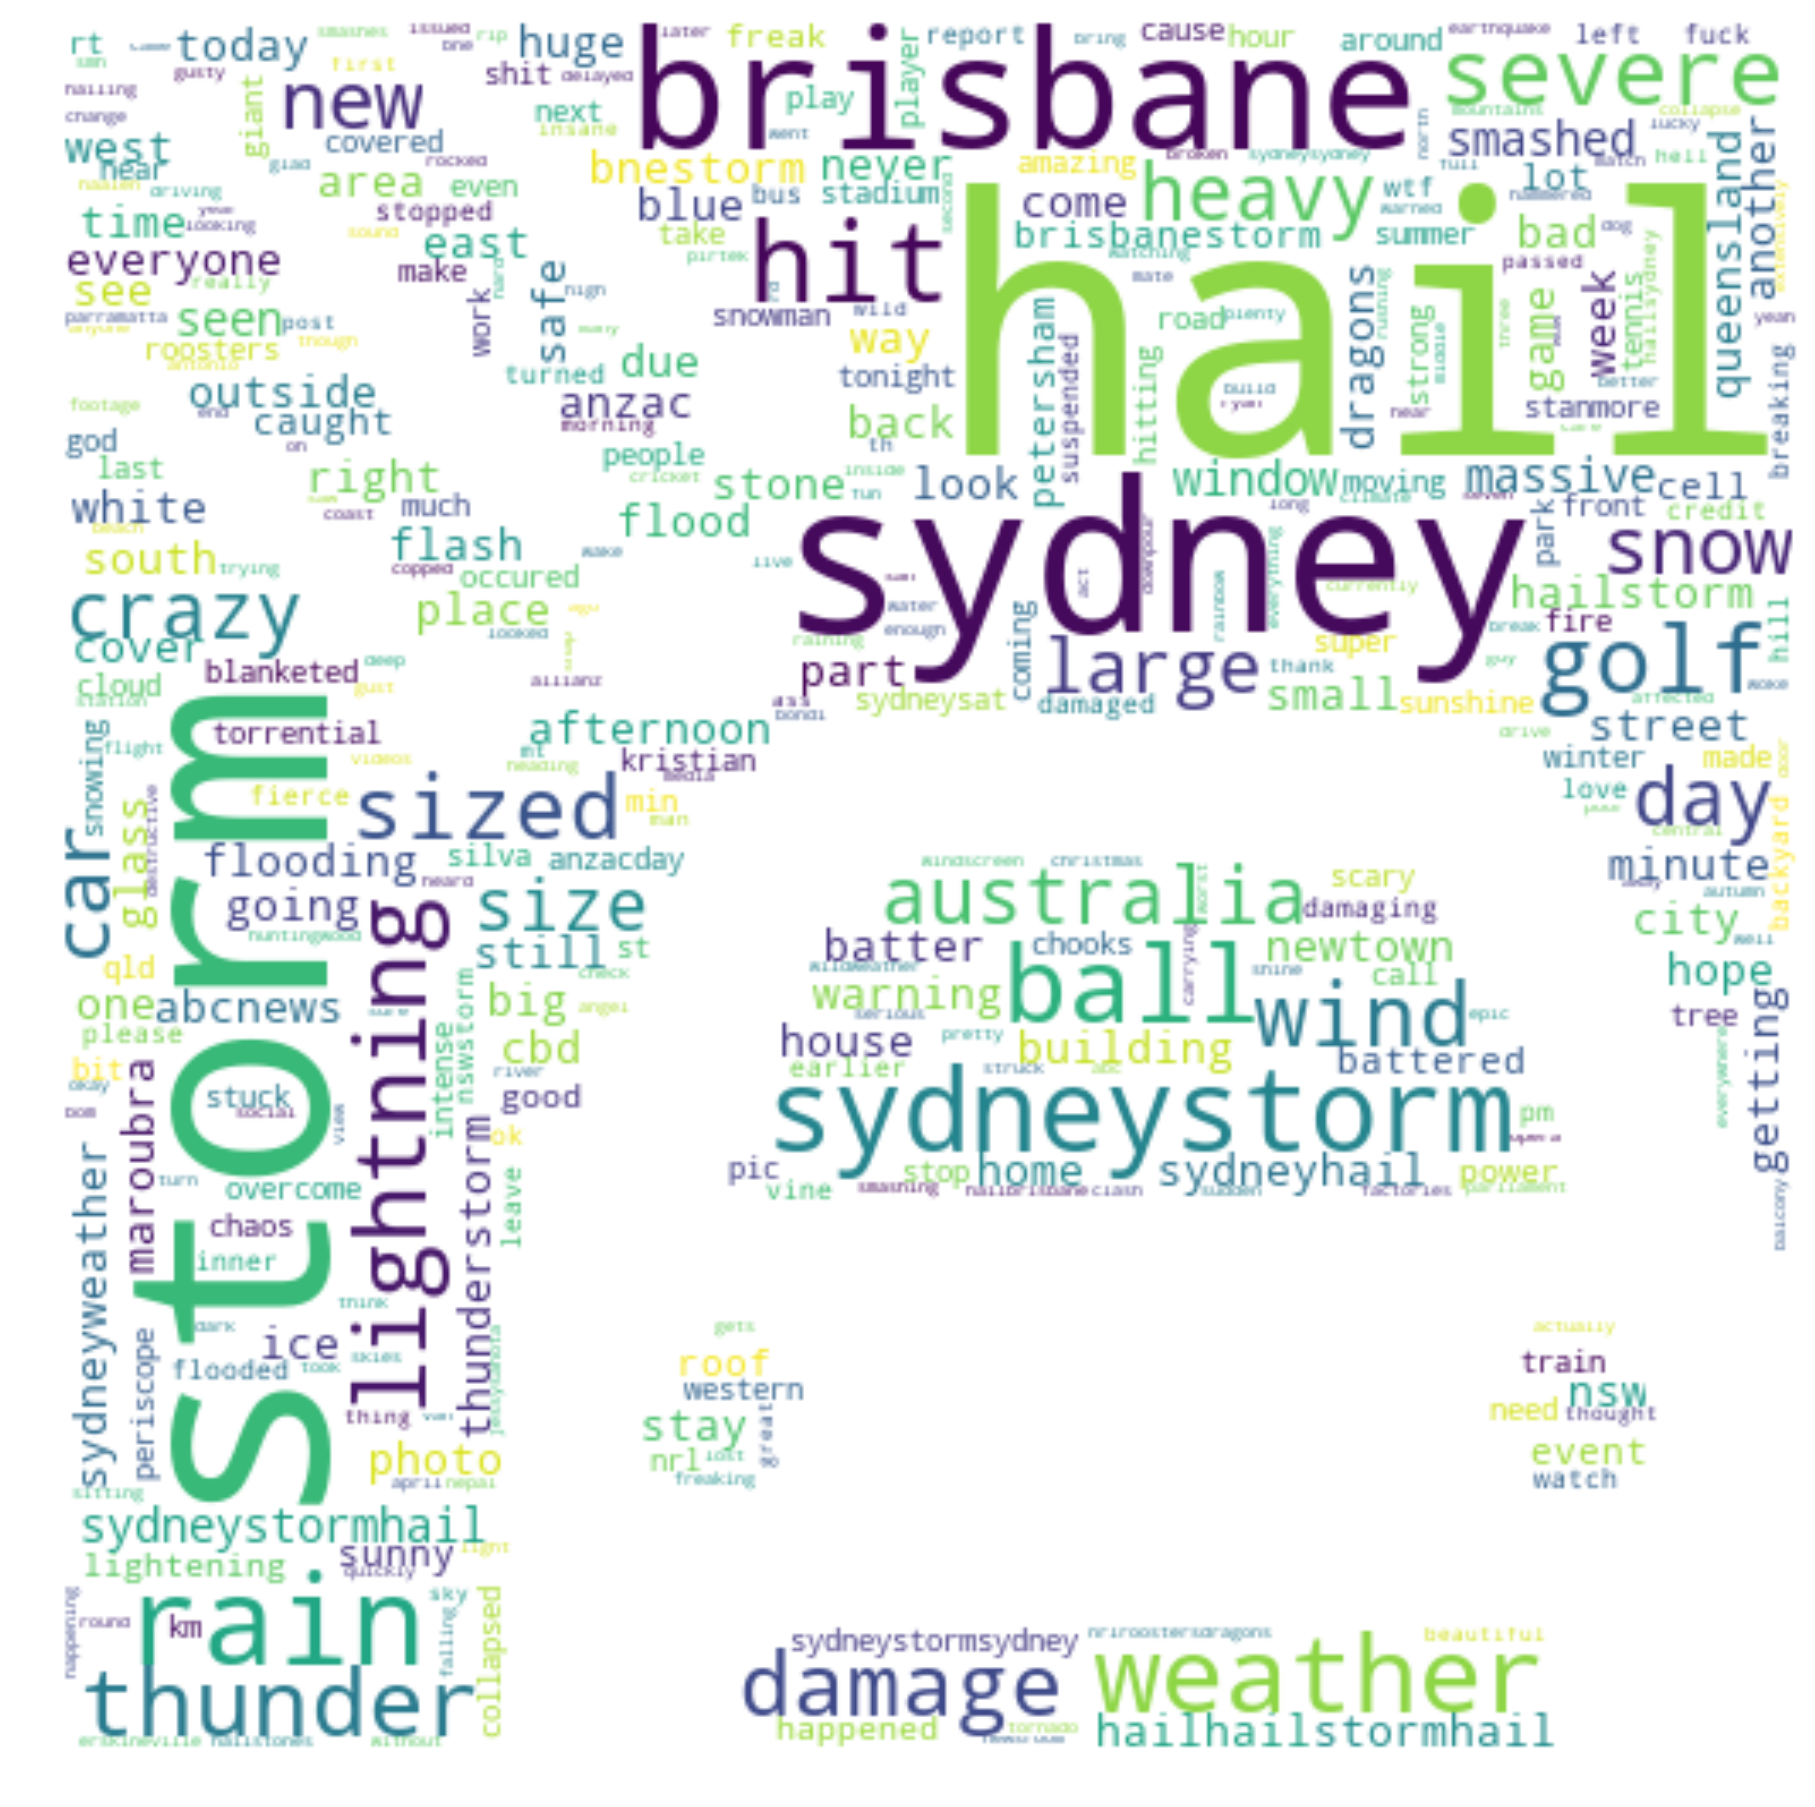

In [98]:
# Finally I will experiment with another visualisation method - a wordcloud.
# This is a package created by amueller on Github: https://github.com/amueller/word_cloud

from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

d = path.dirname('./images/')

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
cloud_mask = np.array(Image.open(path.join(d, "hail.png")))

stopwords = set(STOPWORDS)

text = "".join(hail_tt_storm_hours['tweet_words'])

wc = WordCloud(width=800, height=400, background_color="white", max_words=1000, mask=cloud_mask,collocations=False).generate(text)
# generate word cloud

# store default colored image
default_colors = wc.to_array()
wc.to_file("hail.png")
plt.axis("off")
plt.figure(figsize=(16,16))
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Key hail words insight: 

Storm is the most prevalent word but the two interesting terms used more in the Brisbane event (Cat_ID 144) were 'golf' and 'ball'. As mentioned in previous capstone deliveries, this term is a key indicator of damaging hail. We know already that the Brisbane event was much costlier from an insurance loss perspective, the prevalence of this term in this event is an **excellent indicator of severity!**

---

### Geographic Analysis of Tweet Data

This analysis looks at the geographical distribution of the twitter data over the two 24 hour time periods. 

Some key limitations of this analysis include:
- The coordinate data was minimal in the original data as it relies on twitter users activating location services on their twitter apps to store coordinate data. 
- Ideally the actual tweet location would be used from the location services, however as a proxy, the registeredt location of the user was geocoded externally (using Google's Geocoder API) and appended to the twitter data.
- Only 2234 records successfully geocoded (1.7% of total records).
- Various geocoding resolutions resulted, ranging from city/suburb to country level, so the accuracy of the location is inconsistent.

Despite these limitations, plotting the (known) registered locations of twitter users gives a reasonable geospatial representation of the global tweets over the two sample days.

This analysis uses Folium to create an interactive map.

In [42]:
# Read
hail_tweet_text_geo = pd.read_csv("./hail_tweet_text_geo.csv")
print (len(hail_tweet_text_geo))
hail_tweet_text_geo = hail_tweet_text_geo[hail_tweet_text_geo['longitude']>=-180]
hail_tweet_text_geo = hail_tweet_text_geo[hail_tweet_text_geo['hail']>=1]
                                                                         
latitude = hail_tweet_text_geo['latitude']
longitude = hail_tweet_text_geo['longitude']
print (len(latitude))

import folium
from folium import plugins
import pandas as pd

WORLD_COORDINATES = (0, 0)

# create empty map zoomed in on WORLD

map1 = folium.Map(location=WORLD_COORDINATES, zoom_start=2)

map1.add_child(plugins.HeatMap(zip(latitude, longitude), radius = 10))

map1

127989
221


## 2.iii. LDA - Topic Modelling

I will now investigate the groupings of words within different groups of the dataset. Latent Dirichlet Allocation will help me discover the hidden semantic structures in the twitter data as a a whole, and then subsets relating to different criteria.

The criteria I will investigate includes:
1. The Full Dataset
      - Brisbane Hail Data (Cat_ID = 144)
      - Brisbane Hail Data (Cat_ID = 144) in the known hail storm timeframe (6 - 10 hours)
      - Sydney Hail Data (Cat_ID = 154)
      - Sydney Hail Data (Cat_ID = 154) in the known hail storm timeframe (6 - 10 hours)
  
Firstly I will run through each of the LDA processes for the full dataset. Then I will create an LDA function to parse my remaining critera separately..

In [26]:
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Setup vectorisation

vectorizer = CountVectorizer(stop_words=stops,max_features = 1000)
X = vectorizer.fit_transform(hail_tweet_text['tweet_words'])

# Count the terms in the vectorised vocabulary

from collections import Counter
dict(Counter(vectorizer.vocabulary_).most_common(5))

{'yes': 995, 'yesterday': 996, 'yo': 997, 'york': 998, 'young': 999}

In [27]:
# create a dataframe of words

docs = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())

#Setup dictionary for gensim

vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

dict(Counter(vocab).most_common(5))

{995: 'yes', 996: 'yesterday', 997: 'yo', 998: 'york', 999: 'young'}

In [28]:
# Count the frequency of words

frequency = defaultdict(int)

for text in hail_tweet_text['tweet_words']:
    for token in text.split():
        frequency[token] += 1
        
dict(Counter(frequency).most_common(5))

# Remove single words and stopwords

texts = [[token for token in text.split() if frequency[token] > 1 and token not in stops]
          for text in hail_tweet_text['tweet_words']]

{'damage': 24033,
 'flood': 10882,
 'lightning': 16551,
 'storm': 54421,
 'thunder': 22375}

In [30]:
# Create gensim dictionary object
dictionary = corpora.Dictionary(texts)

dict(Counter(dictionary).most_common(5))

{6172: 'zzz', 13281: 'zz', 23262: 'zzzzz', 31452: 'zzzzzz', 32152: 'zylizzle'}

In [31]:
# Create corpus matrix
corpus = [dictionary.doc2bow(text) for text in texts]
corpus[0:5]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1)],
 [(1, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)],
 [(5, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1)],
 [(5, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1)]]

In [32]:
# Perform LDA modelling

lda = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  3, # found to be optimal
    passes      =  5, # passes reduced due to runtime
    id2word     =  vocab)

# Detection of opportunity:
lda.print_topics(num_topics=3, num_words=10)

[(0,
  '0.132*"thunder" + 0.096*"lightning" + 0.019*"pm" + 0.016*"severe" + 0.016*"warning" + 0.014*"game" + 0.013*"rain" + 0.013*"war" + 0.011*"watch" + 0.010*"win"'),
 (1,
  '0.091*"damage" + 0.071*"storm" + 0.037*"nepal" + 0.027*"earthquake" + 0.018*"hail" + 0.018*"magnitude" + 0.017*"quake" + 0.015*"hits" + 0.013*"causing" + 0.011*"injuries"'),
 (2,
  '0.192*"storm" + 0.073*"flood" + 0.034*"sydney" + 0.029*"sydneystorm" + 0.020*"weather" + 0.018*"new" + 0.017*"see" + 0.012*"ep" + 0.012*"rain" + 0.012*"heroes"')]

In [33]:
# Create a correlation plot function to review our topic modelling groups:

def corr_plot(df):
    pref_corr = df.corr()
    mask = np.zeros_like(pref_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    fig, ax = plt.subplots(figsize=(8,7))

    ax = sns.heatmap(pref_corr, mask=mask)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12, rotation=45)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=0)

    plt.show()

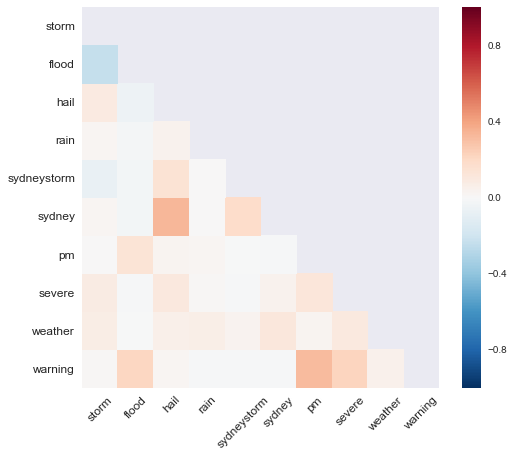

In [62]:
hail_group = hail_tweet_text[['storm','flood','hail','rain','sydneystorm',
                                          'sydney','pm','severe','weather','warning']]
corr_plot(hail_group)

In [35]:
# Create a topic modelling function to use for all groups I want to investigate

def topic_modelling(twitter_data):
    
    vectorizer = CountVectorizer(stop_words=stops,max_features = 1000)
    X = vectorizer.fit_transform(twitter_data)
    
    vectorizer.get_feature_names()
    
    docs = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())

    vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
    
    frequency = defaultdict(int)

    for text in twitter_data:
        for token in text.split():
            frequency[token] += 1
        
    texts = [[token for token in text.split() if frequency[token] > 1 and token not in stops]
          for text in twitter_data]

    dictionary = corpora.Dictionary(texts)
    
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    lda = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  5,
    passes      =  5,
    id2word     =  vocab)

    return lda.print_topics(num_topics=5, num_words=5)

In [36]:
hail_tweet_text_bris = hail_tweet_text[hail_tweet_text['Cat_ID']==144]
print (hail_tweet_text_bris.shape)

topic_modelling(hail_tweet_text_bris['tweet_words'])

(46529, 1026)


[(0,
  '0.143*"lightning" + 0.046*"clean" + 0.020*"black" + 0.020*"one" + 0.019*"amazon"'),
 (1,
  '0.256*"storm" + 0.048*"australia" + 0.017*"way" + 0.016*"calm" + 0.014*"time"'),
 (2,
  '0.150*"damage" + 0.069*"flood" + 0.025*"hail" + 0.023*"cuts" + 0.022*"largest"'),
 (3,
  '0.220*"thunder" + 0.067*"city" + 0.040*"third" + 0.022*"severe" + 0.016*"oklahoma"'),
 (4,
  '0.159*"storm" + 0.114*"brisbane" + 0.050*"power" + 0.041*"thanksgiving" + 0.031*"huge"')]

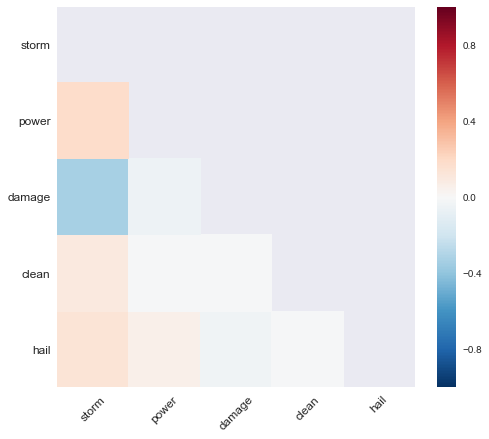

In [61]:
# Correlation plot:

bris_group1 = hail_tweet_text_bris[['storm','power','damage','clean','hail',]]
corr_plot(bris_group1)

In [38]:
# Brisbane Event data (27th Nov 15); Known hours of hailstorm (Hour 6 to 10)

hail_tweet_text_bris_storm = hail_tweet_text_bris[(hail_tweet_text_bris['posted_hour'] >=6) &\
                                            (hail_tweet_text_bris['posted_hour'] <=10)]

topic_modelling(hail_tweet_text_bris_storm['tweet_words'])

[(0,
  '0.120*"damage" + 0.052*"flood" + 0.038*"time" + 0.017*"storm" + 0.012*"one"'),
 (1,
  '0.118*"storm" + 0.062*"brisbane" + 0.042*"hail" + 0.020*"power" + 0.020*"bnestorm"'),
 (2,
  '0.108*"lightning" + 0.052*"storm" + 0.032*"without" + 0.031*"due" + 0.029*"damage"'),
 (3,
  '0.176*"storm" + 0.024*"weather" + 0.018*"flood" + 0.013*"possible" + 0.013*"today"'),
 (4,
  '0.263*"thunder" + 0.045*"city" + 0.039*"spurs" + 0.038*"pacers" + 0.038*"menang"')]

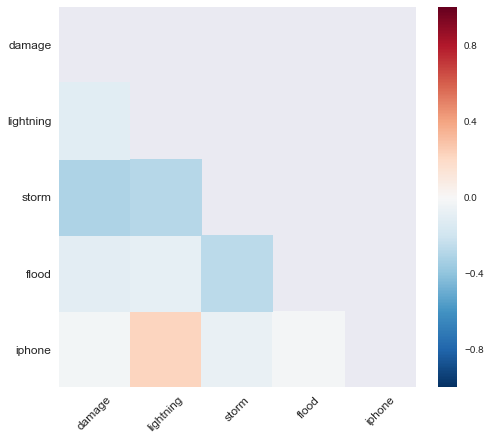

In [60]:
bris_group2 = hail_tweet_text_bris_storm[['damage','lightning','storm','flood','iphone']]
corr_plot(bris_group2)

In [40]:
# Syd topic Modelling

In [41]:
hail_tweet_text_syd = hail_tweet_text[hail_tweet_text['Cat_ID']==154]
hail_tweet_text_syd.shape

(81460, 1026)

In [42]:
# Sydney Hail data (25th April 15)

topic_modelling(hail_tweet_text_syd['tweet_words'])

[(0,
  '0.181*"damage" + 0.082*"nepal" + 0.040*"magnitude" + 0.039*"quake" + 0.034*"hits"'),
 (1,
  '0.102*"flood" + 0.066*"storm" + 0.029*"town" + 0.027*"marte" + 0.027*"borno"'),
 (2,
  '0.200*"storm" + 0.028*"thunder" + 0.013*"time" + 0.009*"love" + 0.009*"purplepride"'),
 (3,
  '0.113*"lightning" + 0.093*"thunder" + 0.085*"earthquake" + 0.025*"rt" + 0.024*"kathmandu"'),
 (4,
  '0.074*"storm" + 0.060*"hail" + 0.040*"sydney" + 0.032*"sydneystorm" + 0.026*"severe"')]

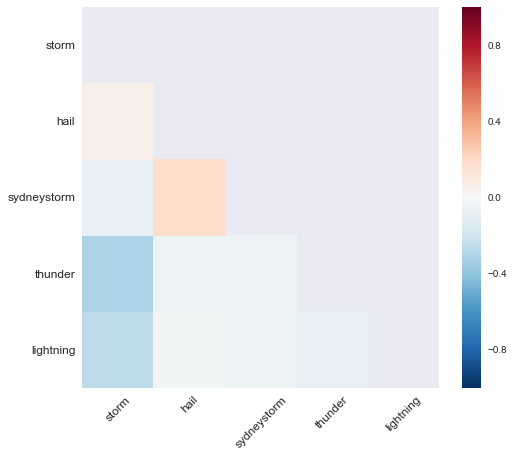

In [59]:
syd_group1 = hail_tweet_text_syd[['storm','hail','sydneystorm','thunder','lightning']]
corr_plot(syd_group1)

In [58]:
# Sydney Hail data (25th April 15); Known hours of hailstorm (Hour 6 to 10)

hail_tweet_text_syd_storm = hail_tweet_text_syd[(hail_tweet_text_syd['posted_hour'] >=6) &\
                                            (hail_tweet_text_syd['posted_hour'] <=10)]

topic_modelling(hail_tweet_text_syd_storm['tweet_words'])

[(0,
  '0.050*"damage" + 0.042*"flood" + 0.026*"hit" + 0.025*"warning" + 0.023*"pm"'),
 (1,
  '0.138*"damage" + 0.108*"nepal" + 0.076*"earthquake" + 0.054*"magnitude" + 0.054*"quake"'),
 (2,
  '0.193*"storm" + 0.065*"hail" + 0.049*"sydney" + 0.043*"sydneystorm" + 0.016*"weather"'),
 (3,
  '0.094*"thunder" + 0.088*"storm" + 0.054*"lightning" + 0.025*"rain" + 0.018*"purplepride"'),
 (4,
  '0.065*"damage" + 0.051*"flood" + 0.040*"thunder" + 0.027*"hope" + 0.020*"old"')]

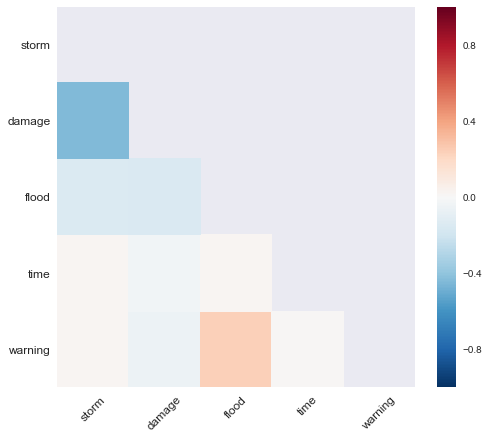

In [57]:
syd_group2 = hail_tweet_text_syd_storm[['storm','damage','flood','time','warning']]
corr_plot(syd_group2)

**Insights of Grouped Topic Modelling:**

The topic modelling groups (the two hail events and their storm durations) improve the recognition of terms likely to be tweeted during hail events (e.g.: meteorology and damage)
No major difference in types of words produced when comparing the Brisbane Hail to the Sydney Hail event and the correlation plots show little improvement between variables than previously observed.
Additional popular events were picked up through this process, including Boko Haram media and Thanksgiving.


## 2.iv. Sentiment Analysis:

In [47]:
from textblob import TextBlob, Word

def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [48]:
# create a new DataFrame column for sentiment (WARNING: SLOW!)
hail_tweet_text['sentiment'] = hail_tweet_text.Text.apply(detect_sentiment)

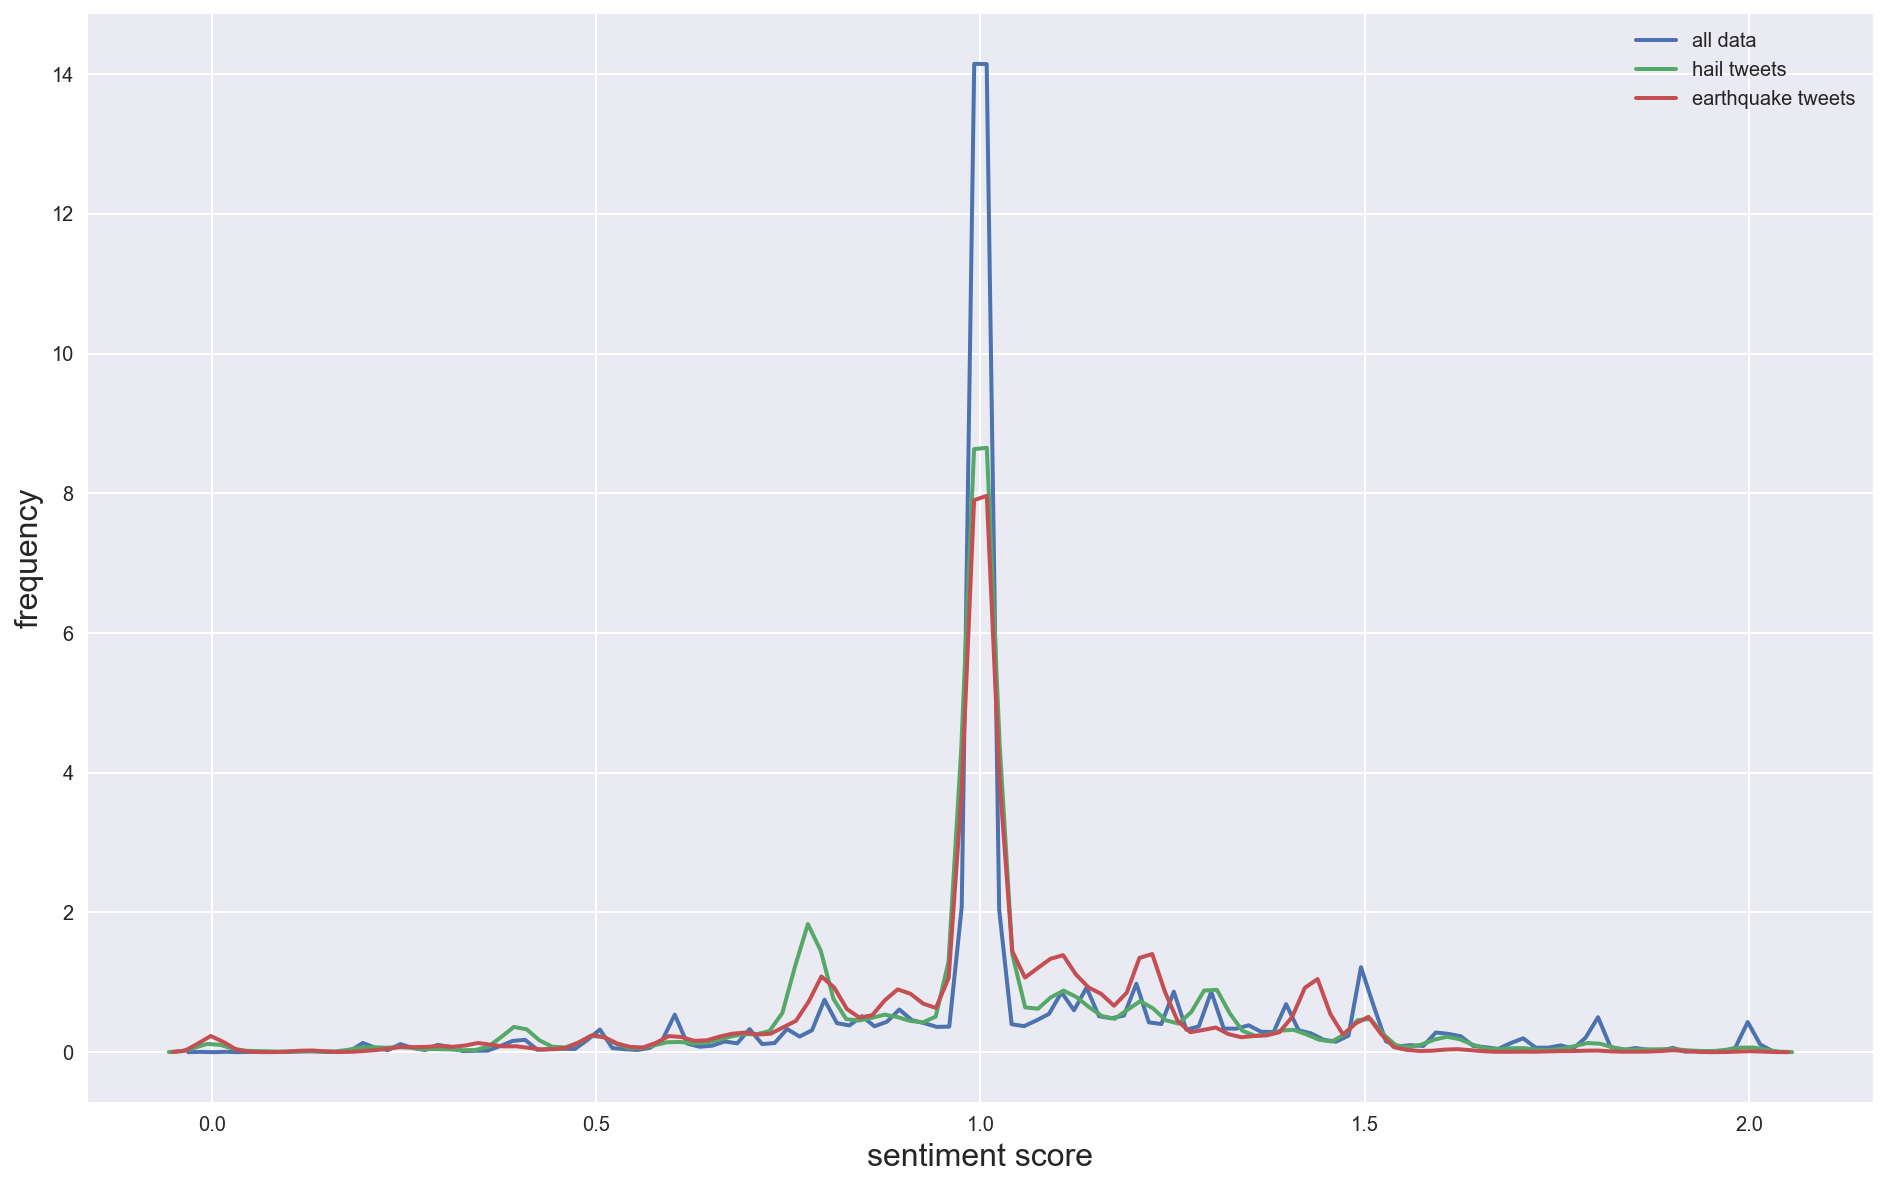

In [69]:
hail_tweets = hail_tweet_text.loc[hail_tweet_text['hail'] >= 1]
eq_tweets = hail_tweet_text.loc[hail_tweet_text['earthquake'] >= 1]

fig, ax = plt.subplots(figsize=(16,10))
sns.distplot(hail_tweet_text['sentiment'],hist=False,kde_kws={"lw": 2, "label": "all data"})
sns.distplot(hail_tweets['sentiment'],hist=False,kde_kws={"lw": 2, "label": "hail tweets"})
sns.distplot(eq_tweets['sentiment'],hist=False,kde_kws={"lw": 2, "label": "earthquake tweets"})
ax.set_xlabel('sentiment score', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)

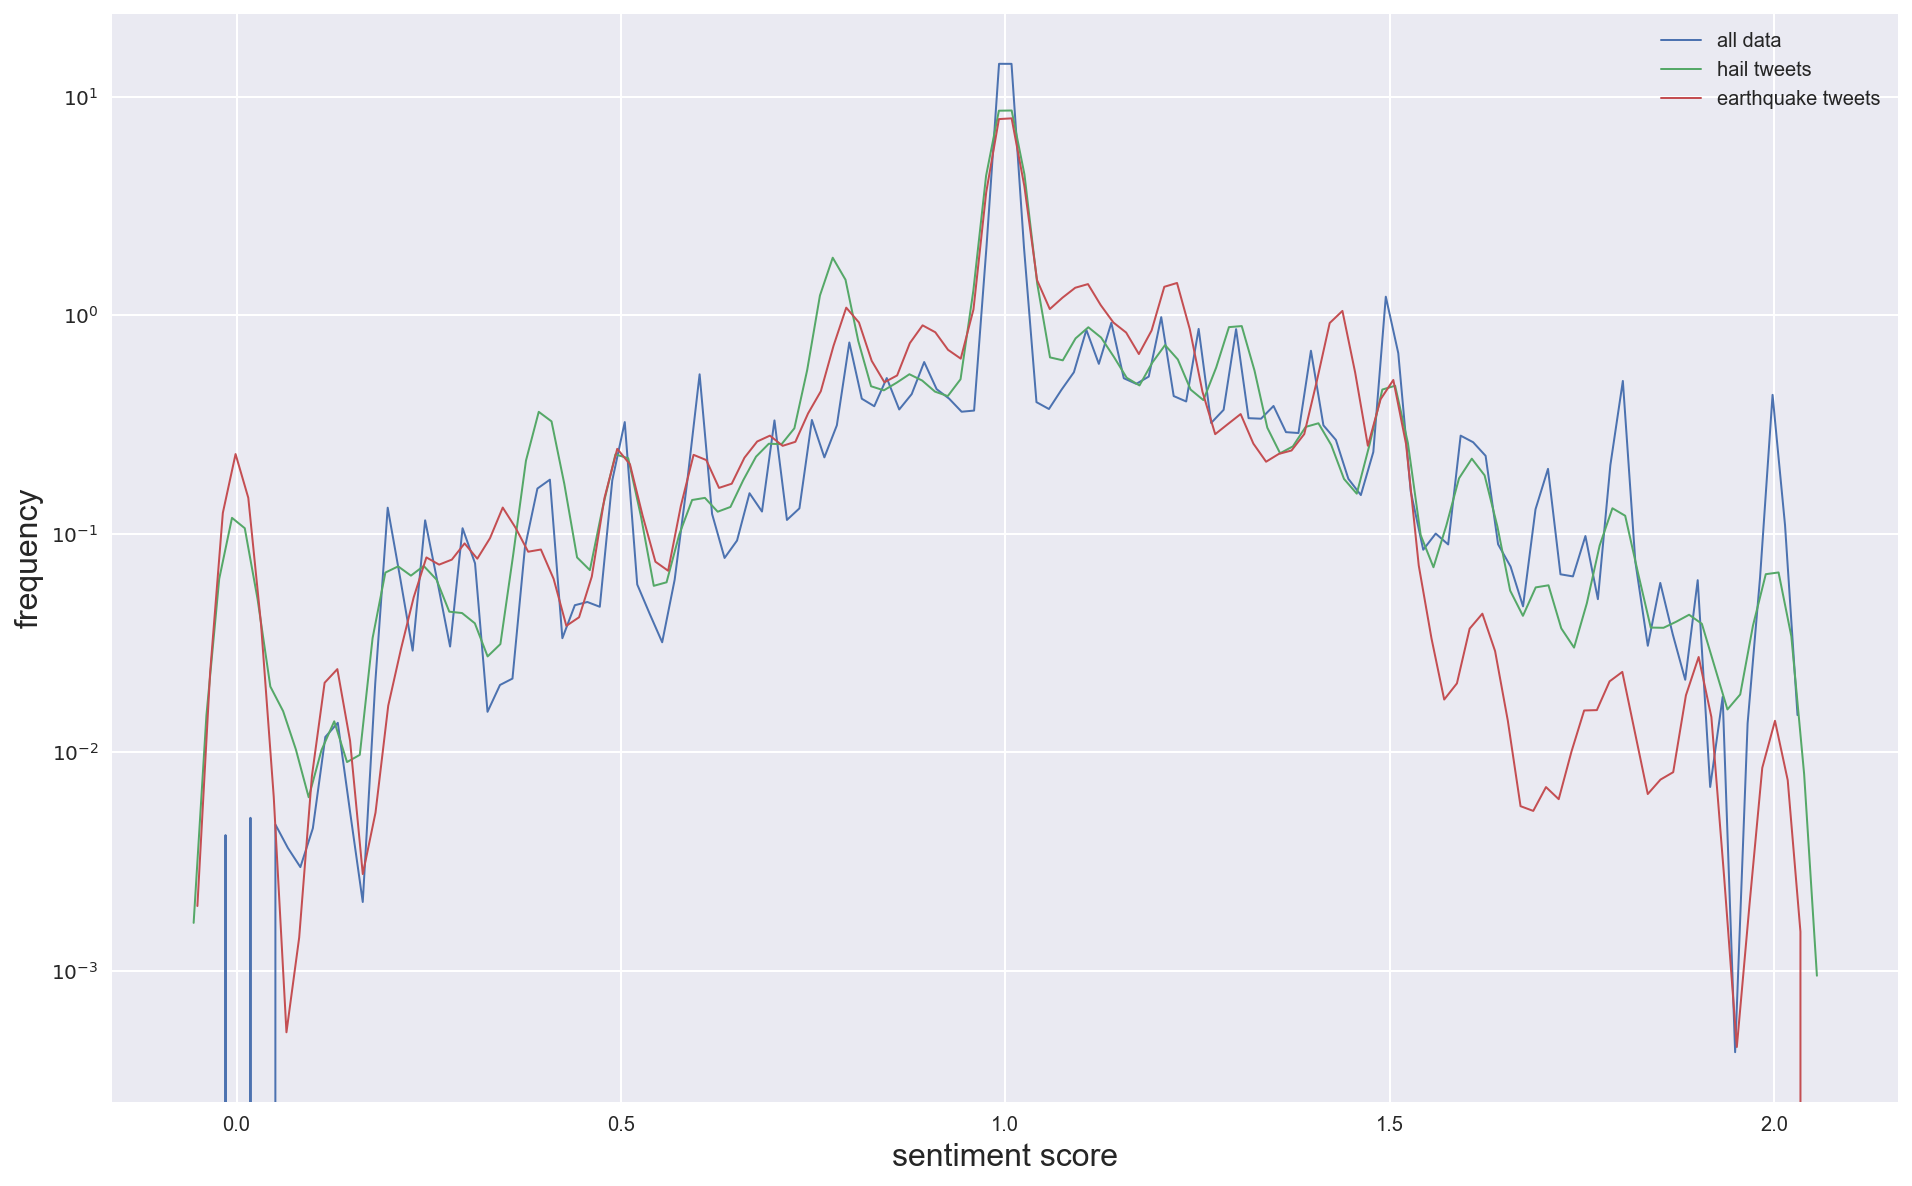

In [70]:
hail_tweets = hail_tweet_text.loc[hail_tweet_text['hail'] >= 1]
eq_tweets = hail_tweet_text.loc[hail_tweet_text['earthquake'] >= 1]

fig, ax = plt.subplots(figsize=(16,10))
sns.distplot(hail_tweet_text['sentiment'],hist=False,kde_kws={"lw": 1, "label": "all data"})
sns.distplot(hail_tweets['sentiment'],hist=False,kde_kws={"lw": 1, "label": "hail tweets"})
sns.distplot(eq_tweets['sentiment'],hist=False,kde_kws={"lw": 1, "label": "earthquake tweets"})
ax.set_xlabel('sentiment score', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
plt.yscale('log')

**Sentiment Analysis Insights**

....

In [51]:
# Adjust sentiment score above 0

hail_tweet_text['sentiment'] = hail_tweet_text['sentiment']+1.0

In [52]:
# Save final processed tweet data into a csv to use for modelling:

hail_tweet_text.to_csv("./hail_tweet_text.csv")

### Link to [Notebook 3](capstone_technical_report_3_HailModelling)

----